# Notebook to train CNNs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from monai.networks.nets import ResNet
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

/home/diogommiranda/tese/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-09 14:05:28.643968: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-09 14:05:30.147033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


In [2]:
NORMALIZATION = "mni_reg_CV" # Choose intensity normalization method: "minmax"
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 16 # Set batch size

USE_MASK = False # Set to True to use the ROI mask, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
    Found 575 files for class 'smci'
    Found 314 files for class 'pmci'
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
    Found 143 files for class 'smci'
    Found 78 files for class 'pmci'


torch.Size([1, 91, 109, 91])


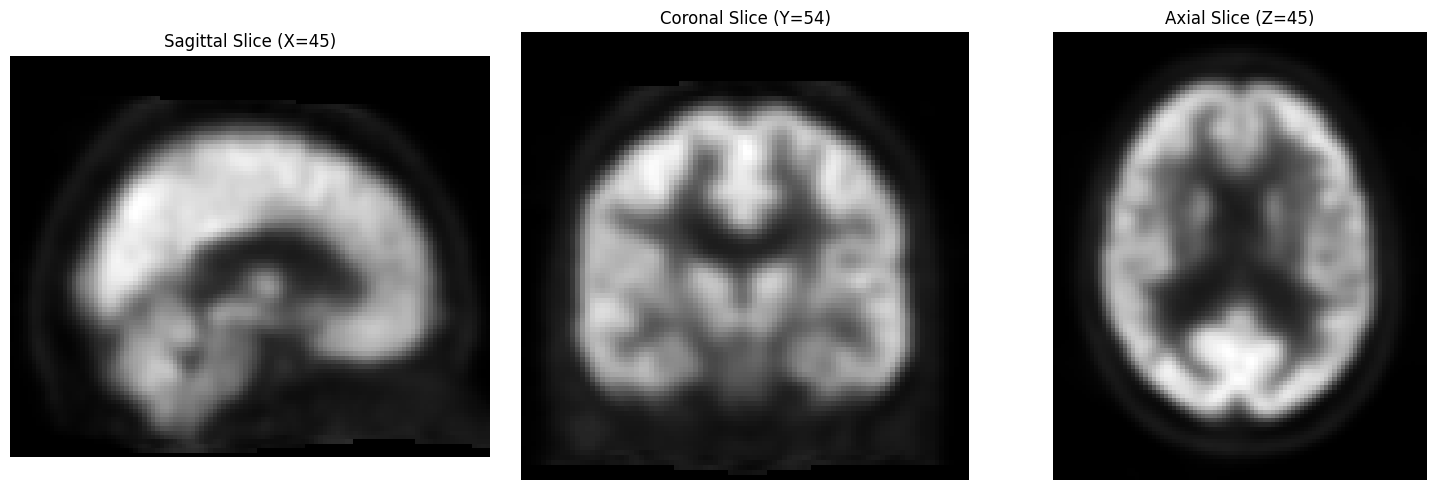

In [3]:
# Verify data with a test sample
i = 2
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    break

In [ ]:

# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation

# para cosine decay
#learning_rates = [5e-4, 2e-4, 1e-4] # adicionar 1e-3? ver os resultados
#weight_decays = [5e-4, 2e-4, 1e-4]

#para fixed_lr
#learning_rates = [1e-5, 2e-5] # adicionar 4e-5 ou 5e-6 dependendo dos resultados
#weight_decays = [2e-4, 1e-4] # adicionar 4e-4 ou 5e-5 dependendo dos resultados

lr_scheduler = "fixed_lr" # Choose between "cosine_decay" or "fixed_lr"

if lr_scheduler == "cosine_decay":
    NUM_EPOCHS = 100
    EARLY_STOP_PATIENCE = 60
    T_max = 100
    eta_min = 0
else:
    NUM_EPOCHS = 150
    EARLY_STOP_PATIENCE = 60
1
learning_rates = [2e-5] # usar valores a volta do 1e-6 (ate agr a combinacao com l2=1e-4 ou 5e-4 pareceu a melhor com val loss min de 0.24 em 32 epochs)
weight_decays = [2e-4]

tuning_results = []
total_combinations = len(learning_rates) * len(weight_decays)
current_combination_no = 0

if ROI_MASK_PATH is None:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/cosine_decay/" + str(BATCH_SIZE) + "B/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/fixed_lr/" + str(BATCH_SIZE) + "B/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")
else:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/masked/" + DATASET + "/cosine_decay/" + str(BATCH_SIZE) + "B/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/masked/" + DATASET + "/fixed_lr/" + str(BATCH_SIZE) + "B/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

print("\nStarting Hyperparameter Tuning Grid Search...")
overall_start_time = time.time()

# Hyperparameter tuning loop
for current_lr in learning_rates:
    for current_wd in weight_decays: 
        current_combination_no += 1
        print("=" * 60)
        print(f"Testing Combination {current_combination_no}/{total_combinations}: LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
        print("=" * 60)
        start_time_combination = time.time()

        combo_dir_name = f"LR0_{current_lr:.1e}_WD_{current_wd:.0e}" 
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")

        current_combo_val_losses = []
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []

        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                 raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )

            if fold_train_data is None or fold_val_data is None:
                 raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
             
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            model = ResNet(
                block='basic',
                layers=[3, 4, 6, 3],
                block_inplanes=[64, 128, 256, 512],
                spatial_dims=3,
                n_input_channels=1,
                conv1_t_stride=2,
                num_classes=1,
                shortcut_type='B',
                bias_downsample = False
            )
            model.to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            #optimizer = optim.AdamW(model.parameters(), lr=current_lr, weight_decay=current_wd)
            #optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)
            optimizer = optim.SGD(model.parameters(), lr=current_lr, weight_decay=current_wd, momentum=0.9, nesterov=True)
                        
            scheduler = None
            if lr_scheduler == "cosine_decay":
                print("\nUsing Cosine Annealing LR Scheduler.\n")
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    
            best_val_loss = float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # Train phase
                model.train()
                running_loss = 0.0
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())
 
                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # Validation phase
                model.eval()
                val_running_loss = 0.0
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = val_running_loss / len(fold_val_data.dataset)
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                      f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                      f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                
                if scheduler:
                    scheduler.step()

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    # Save the best model state
                    best_model_state = model.state_dict()
                    best_epoch = epoch + 1
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    stopped_epoch = epoch + 1
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {stopped_epoch - epochs_no_improve}.\n")
                    break
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history['val_loss'][best_epoch_index]
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            # Save optimizer name to use in the saving files
            optimizer_name = optimizer.__class__.__name__
        
            # Free resources
            del model, optimizer, criterion, scheduler, fold_train_data, fold_val_data, history, history_df, best_model_state
            if device.type == 'cuda':
                torch.cuda.empty_cache() 
            gc.collect() 
            
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)

        print("-" * 50)
        print(f"Results for LR={current_lr}, WeightDecay={current_wd} (Across {N_SPLITS} Folds):")
        print(f"  Avg Val Loss: {avg_loss:.4f} +/- {std_loss:.4f}")
        print(f"  Avg Val Acc:  {avg_acc:.4f} +/- {std_acc:.4f}")
        print(f"  Avg Val AUC:  {avg_auc:.4f} +/- {std_auc:.4f}")
        print("-" * 50)

        # Store results
        
        combo_average_results = {
            'learning_rate': current_lr,
            'weight_decay': current_wd,
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch)
        }
        
        tuning_results.append(combo_average_results)
        
        results_df = pd.DataFrame(combo_average_results)
        display_cols = list(combo_average_results.keys())
        
        results_file_path = os.path.join(combo_results_dir, "resultados.txt")
        with open(results_file_path, "w") as f:
            print("\nTuning Results Summary:", file=f)
            print(results_df[display_cols].round(6).to_string(index=False), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)
        
        training_config = {
            "num_folds": N_SPLITS,
            "num_epochs": NUM_EPOCHS,
            "early_stop_patience": EARLY_STOP_PATIENCE,
            "lr_scheduler": lr_scheduler,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(current_lr),
                "weight_decay": float(current_wd)
            },
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(combo_results_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)

        end_time_combination = time.time()
        print(f"Combination {current_combination_no} finished in {end_time_combination - start_time_combination:.2f} seconds.")
        


Results will be saved to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/16B/

Starting Hyperparameter Tuning Grid Search...
Testing Combination 1/1: LR=2.0e-05, WeightDecay=2e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/16B/LR0_2.0e-05_WD_2e-04
------------------------------------------------------------
Training Fold 1/5 for LR=2.0e-05 and WD=2e-04...
  Train samples: 726, Validation samples: 163
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 472, 1: 254}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8583


  1%|          | 1/150 [00:06<14:58,  6.03s/it]

    Epoch 1/150 [6.03s] - Train Loss: 0.90665, Train Acc: 0.38567 | Val Loss: 0.91317, Val Acc: 0.35583


  1%|▏         | 2/150 [00:12<15:08,  6.14s/it]

    Epoch 2/150 [6.21s] - Train Loss: 0.89739, Train Acc: 0.56061 | Val Loss: 0.91238, Val Acc: 0.53988


  2%|▏         | 3/150 [00:18<14:45,  6.02s/it]

    Epoch 3/150 [5.88s] - Train Loss: 0.88921, Train Acc: 0.60055 | Val Loss: 0.89101, Val Acc: 0.54601


  3%|▎         | 4/150 [00:23<14:28,  5.95s/it]

    Epoch 4/150 [5.83s] - Train Loss: 0.87739, Train Acc: 0.67631 | Val Loss: 0.90629, Val Acc: 0.50307


  3%|▎         | 5/150 [00:31<15:46,  6.53s/it]

    Epoch 5/150 [7.56s] - Train Loss: 0.86452, Train Acc: 0.74793 | Val Loss: 0.89244, Val Acc: 0.66258


  4%|▍         | 6/150 [00:37<15:07,  6.30s/it]

    Epoch 6/150 [5.86s] - Train Loss: 0.85237, Train Acc: 0.70661 | Val Loss: 0.89017, Val Acc: 0.66258


  5%|▍         | 7/150 [00:43<14:45,  6.19s/it]

    Epoch 7/150 [5.97s] - Train Loss: 0.82915, Train Acc: 0.76033 | Val Loss: 0.87756, Val Acc: 0.74233


  5%|▌         | 8/150 [00:49<14:26,  6.10s/it]

    Epoch 8/150 [5.90s] - Train Loss: 0.80754, Train Acc: 0.83471 | Val Loss: 0.86694, Val Acc: 0.76074


  6%|▌         | 9/150 [00:55<14:15,  6.06s/it]

    Epoch 9/150 [5.98s] - Train Loss: 0.79341, Train Acc: 0.83333 | Val Loss: 0.85072, Val Acc: 0.76074


  7%|▋         | 10/150 [01:01<13:59,  6.00s/it]

    Epoch 10/150 [5.85s] - Train Loss: 0.77599, Train Acc: 0.84573 | Val Loss: 0.83779, Val Acc: 0.75460


  7%|▋         | 11/150 [01:08<15:10,  6.55s/it]

    Epoch 11/150 [7.79s] - Train Loss: 0.75504, Train Acc: 0.85537 | Val Loss: 0.82122, Val Acc: 0.79755


  8%|▊         | 12/150 [01:14<14:39,  6.38s/it]

    Epoch 12/150 [5.98s] - Train Loss: 0.72641, Train Acc: 0.87879 | Val Loss: 0.82299, Val Acc: 0.73620


  9%|▊         | 13/150 [01:20<14:13,  6.23s/it]

    Epoch 13/150 [5.88s] - Train Loss: 0.70826, Train Acc: 0.88430 | Val Loss: 0.82776, Val Acc: 0.77914


  9%|▉         | 14/150 [01:26<13:58,  6.16s/it]

    Epoch 14/150 [6.01s] - Train Loss: 0.68503, Train Acc: 0.87466 | Val Loss: 0.79764, Val Acc: 0.78528


 10%|█         | 15/150 [01:32<13:45,  6.12s/it]

    Epoch 15/150 [6.01s] - Train Loss: 0.65797, Train Acc: 0.88843 | Val Loss: 0.80202, Val Acc: 0.79755


 11%|█         | 16/150 [01:40<14:28,  6.48s/it]

    Epoch 16/150 [7.33s] - Train Loss: 0.64669, Train Acc: 0.88430 | Val Loss: 0.78401, Val Acc: 0.80368


 11%|█▏        | 17/150 [01:45<13:56,  6.29s/it]

    Epoch 17/150 [5.83s] - Train Loss: 0.62415, Train Acc: 0.89394 | Val Loss: 0.76182, Val Acc: 0.79755


 12%|█▏        | 18/150 [01:51<13:39,  6.21s/it]

    Epoch 18/150 [6.01s] - Train Loss: 0.60360, Train Acc: 0.88981 | Val Loss: 0.76404, Val Acc: 0.80982


 13%|█▎        | 19/150 [01:57<13:24,  6.14s/it]

    Epoch 19/150 [6.00s] - Train Loss: 0.57788, Train Acc: 0.89394 | Val Loss: 0.74271, Val Acc: 0.80982


 13%|█▎        | 20/150 [02:03<13:13,  6.10s/it]

    Epoch 20/150 [6.00s] - Train Loss: 0.56205, Train Acc: 0.90220 | Val Loss: 0.73386, Val Acc: 0.80982


 14%|█▍        | 21/150 [02:11<14:12,  6.61s/it]

    Epoch 21/150 [7.80s] - Train Loss: 0.53830, Train Acc: 0.91598 | Val Loss: 0.71129, Val Acc: 0.80368


 15%|█▍        | 22/150 [02:17<13:43,  6.43s/it]

    Epoch 22/150 [6.02s] - Train Loss: 0.51644, Train Acc: 0.92700 | Val Loss: 0.71281, Val Acc: 0.80368


 15%|█▌        | 23/150 [02:23<13:17,  6.28s/it]

    Epoch 23/150 [5.92s] - Train Loss: 0.49172, Train Acc: 0.91322 | Val Loss: 0.69511, Val Acc: 0.80368


 16%|█▌        | 24/150 [02:29<12:52,  6.13s/it]

    Epoch 24/150 [5.79s] - Train Loss: 0.47615, Train Acc: 0.92562 | Val Loss: 0.72208, Val Acc: 0.80368


 17%|█▋        | 25/150 [02:35<12:38,  6.07s/it]

    Epoch 25/150 [5.91s] - Train Loss: 0.44724, Train Acc: 0.92700 | Val Loss: 0.68456, Val Acc: 0.79755


 17%|█▋        | 26/150 [02:41<12:22,  5.98s/it]

    Epoch 26/150 [5.79s] - Train Loss: 0.44067, Train Acc: 0.91873 | Val Loss: 0.67705, Val Acc: 0.80368


 18%|█▊        | 27/150 [02:48<13:11,  6.44s/it]

    Epoch 27/150 [7.49s] - Train Loss: 0.40566, Train Acc: 0.93664 | Val Loss: 0.66831, Val Acc: 0.80982


 19%|█▊        | 28/150 [02:54<12:42,  6.25s/it]

    Epoch 28/150 [5.81s] - Train Loss: 0.39937, Train Acc: 0.93388 | Val Loss: 0.68050, Val Acc: 0.79755


 19%|█▉        | 29/150 [03:00<12:19,  6.11s/it]

    Epoch 29/150 [5.78s] - Train Loss: 0.37798, Train Acc: 0.92975 | Val Loss: 0.66837, Val Acc: 0.81595


 20%|██        | 30/150 [03:06<12:01,  6.01s/it]

    Epoch 30/150 [5.78s] - Train Loss: 0.35890, Train Acc: 0.94904 | Val Loss: 0.66801, Val Acc: 0.79755


 21%|██        | 31/150 [03:11<11:49,  5.96s/it]

    Epoch 31/150 [5.85s] - Train Loss: 0.34622, Train Acc: 0.93939 | Val Loss: 0.63495, Val Acc: 0.80982


 21%|██▏       | 32/150 [03:19<12:37,  6.42s/it]

    Epoch 32/150 [7.48s] - Train Loss: 0.31809, Train Acc: 0.95179 | Val Loss: 0.66515, Val Acc: 0.80368


 22%|██▏       | 33/150 [03:25<12:08,  6.23s/it]

    Epoch 33/150 [5.79s] - Train Loss: 0.31074, Train Acc: 0.95179 | Val Loss: 0.68288, Val Acc: 0.80368


 23%|██▎       | 34/150 [03:30<11:47,  6.10s/it]

    Epoch 34/150 [5.79s] - Train Loss: 0.29553, Train Acc: 0.95592 | Val Loss: 0.64214, Val Acc: 0.80368


 23%|██▎       | 35/150 [03:36<11:30,  6.00s/it]

    Epoch 35/150 [5.77s] - Train Loss: 0.27571, Train Acc: 0.95455 | Val Loss: 0.66475, Val Acc: 0.80982


 24%|██▍       | 36/150 [03:42<11:16,  5.94s/it]

    Epoch 36/150 [5.78s] - Train Loss: 0.25823, Train Acc: 0.96419 | Val Loss: 0.67968, Val Acc: 0.80982


 25%|██▍       | 37/150 [03:48<11:05,  5.89s/it]

    Epoch 37/150 [5.79s] - Train Loss: 0.26884, Train Acc: 0.95730 | Val Loss: 0.61108, Val Acc: 0.82209


 25%|██▌       | 38/150 [03:55<11:54,  6.38s/it]

    Epoch 38/150 [7.50s] - Train Loss: 0.24803, Train Acc: 0.96281 | Val Loss: 0.65564, Val Acc: 0.79755


 26%|██▌       | 39/150 [04:01<11:28,  6.20s/it]

    Epoch 39/150 [5.80s] - Train Loss: 0.21940, Train Acc: 0.97107 | Val Loss: 0.64893, Val Acc: 0.80368


 27%|██▋       | 40/150 [04:07<11:08,  6.07s/it]

    Epoch 40/150 [5.77s] - Train Loss: 0.21993, Train Acc: 0.96832 | Val Loss: 0.65135, Val Acc: 0.80368


 27%|██▋       | 41/150 [04:13<10:52,  5.99s/it]

    Epoch 41/150 [5.79s] - Train Loss: 0.19482, Train Acc: 0.97383 | Val Loss: 0.61647, Val Acc: 0.81595


 28%|██▊       | 42/150 [04:18<10:40,  5.93s/it]

    Epoch 42/150 [5.79s] - Train Loss: 0.19537, Train Acc: 0.97383 | Val Loss: 0.67077, Val Acc: 0.80982


 29%|██▊       | 43/150 [04:24<10:31,  5.90s/it]

    Epoch 43/150 [5.82s] - Train Loss: 0.18633, Train Acc: 0.97107 | Val Loss: 0.67303, Val Acc: 0.81595


 29%|██▉       | 44/150 [04:32<11:16,  6.38s/it]

    Epoch 44/150 [7.51s] - Train Loss: 0.15521, Train Acc: 0.98760 | Val Loss: 0.65909, Val Acc: 0.81595


 30%|███       | 45/150 [04:38<10:52,  6.21s/it]

    Epoch 45/150 [5.82s] - Train Loss: 0.18600, Train Acc: 0.97934 | Val Loss: 0.61784, Val Acc: 0.81595


 31%|███       | 46/150 [04:43<10:32,  6.08s/it]

    Epoch 46/150 [5.78s] - Train Loss: 0.15311, Train Acc: 0.98623 | Val Loss: 0.68951, Val Acc: 0.81595


 31%|███▏      | 47/150 [04:49<10:16,  5.99s/it]

    Epoch 47/150 [5.77s] - Train Loss: 0.15537, Train Acc: 0.97934 | Val Loss: 0.63620, Val Acc: 0.79141


 32%|███▏      | 48/150 [04:55<10:06,  5.94s/it]

    Epoch 48/150 [5.83s] - Train Loss: 0.13982, Train Acc: 0.99449 | Val Loss: 0.65728, Val Acc: 0.80368


 33%|███▎      | 49/150 [05:03<10:47,  6.41s/it]

    Epoch 49/150 [7.51s] - Train Loss: 0.14129, Train Acc: 0.99174 | Val Loss: 0.67480, Val Acc: 0.80982


 33%|███▎      | 50/150 [05:08<10:23,  6.24s/it]

    Epoch 50/150 [5.82s] - Train Loss: 0.13539, Train Acc: 0.98485 | Val Loss: 0.65621, Val Acc: 0.81595


 34%|███▍      | 51/150 [05:14<10:03,  6.09s/it]

    Epoch 51/150 [5.76s] - Train Loss: 0.11716, Train Acc: 0.98898 | Val Loss: 0.62708, Val Acc: 0.78528


 35%|███▍      | 52/150 [05:20<09:47,  6.00s/it]

    Epoch 52/150 [5.77s] - Train Loss: 0.12652, Train Acc: 0.98623 | Val Loss: 0.66770, Val Acc: 0.80368


 35%|███▌      | 53/150 [05:26<09:36,  5.94s/it]

    Epoch 53/150 [5.81s] - Train Loss: 0.13134, Train Acc: 0.98347 | Val Loss: 0.68415, Val Acc: 0.81595


 36%|███▌      | 54/150 [05:32<09:27,  5.91s/it]

    Epoch 54/150 [5.82s] - Train Loss: 0.09751, Train Acc: 0.99449 | Val Loss: 0.62390, Val Acc: 0.80368


 37%|███▋      | 55/150 [05:39<10:10,  6.42s/it]

    Epoch 55/150 [7.63s] - Train Loss: 0.10527, Train Acc: 0.99449 | Val Loss: 0.69150, Val Acc: 0.80982


 37%|███▋      | 56/150 [05:45<09:46,  6.24s/it]

    Epoch 56/150 [5.80s] - Train Loss: 0.09617, Train Acc: 0.99587 | Val Loss: 0.67352, Val Acc: 0.80368


 38%|███▊      | 57/150 [05:51<09:24,  6.07s/it]

    Epoch 57/150 [5.69s] - Train Loss: 0.09937, Train Acc: 0.99174 | Val Loss: 0.66762, Val Acc: 0.79141


 39%|███▊      | 58/150 [05:56<09:11,  6.00s/it]

    Epoch 58/150 [5.82s] - Train Loss: 0.08852, Train Acc: 0.99449 | Val Loss: 0.65494, Val Acc: 0.80368


 39%|███▉      | 59/150 [06:02<09:00,  5.94s/it]

    Epoch 59/150 [5.81s] - Train Loss: 0.09378, Train Acc: 0.99311 | Val Loss: 0.65536, Val Acc: 0.79755


 40%|████      | 60/150 [06:10<09:41,  6.47s/it]

    Epoch 60/150 [7.69s] - Train Loss: 0.08046, Train Acc: 0.99449 | Val Loss: 0.65347, Val Acc: 0.80368


 41%|████      | 61/150 [06:16<09:21,  6.31s/it]

    Epoch 61/150 [5.96s] - Train Loss: 0.07087, Train Acc: 1.00000 | Val Loss: 0.64569, Val Acc: 0.80982


 41%|████▏     | 62/150 [06:22<09:02,  6.16s/it]

    Epoch 62/150 [5.80s] - Train Loss: 0.06393, Train Acc: 1.00000 | Val Loss: 0.67899, Val Acc: 0.80982


 42%|████▏     | 63/150 [06:27<08:45,  6.04s/it]

    Epoch 63/150 [5.74s] - Train Loss: 0.07821, Train Acc: 0.99862 | Val Loss: 0.65238, Val Acc: 0.79141


 43%|████▎     | 64/150 [06:33<08:32,  5.96s/it]

    Epoch 64/150 [5.77s] - Train Loss: 0.06245, Train Acc: 1.00000 | Val Loss: 0.71028, Val Acc: 0.82209


 43%|████▎     | 65/150 [06:39<08:23,  5.92s/it]

    Epoch 65/150 [5.83s] - Train Loss: 0.06800, Train Acc: 0.99725 | Val Loss: 0.78870, Val Acc: 0.80982


 44%|████▍     | 66/150 [06:47<09:00,  6.43s/it]

    Epoch 66/150 [7.62s] - Train Loss: 0.05040, Train Acc: 1.00000 | Val Loss: 0.70996, Val Acc: 0.81595


 45%|████▍     | 67/150 [06:53<08:39,  6.26s/it]

    Epoch 67/150 [5.86s] - Train Loss: 0.07552, Train Acc: 0.99311 | Val Loss: 0.70436, Val Acc: 0.81595


 45%|████▌     | 68/150 [06:58<08:23,  6.14s/it]

    Epoch 68/150 [5.86s] - Train Loss: 0.06105, Train Acc: 0.99587 | Val Loss: 0.76780, Val Acc: 0.79141


 46%|████▌     | 69/150 [07:04<08:06,  6.00s/it]

    Epoch 69/150 [5.69s] - Train Loss: 0.06189, Train Acc: 0.99725 | Val Loss: 0.67011, Val Acc: 0.79755


 47%|████▋     | 70/150 [07:10<07:55,  5.95s/it]

    Epoch 70/150 [5.82s] - Train Loss: 0.05706, Train Acc: 0.99862 | Val Loss: 0.63998, Val Acc: 0.80368


 47%|████▋     | 71/150 [07:18<08:28,  6.43s/it]

    Epoch 71/150 [7.57s] - Train Loss: 0.05768, Train Acc: 1.00000 | Val Loss: 0.67383, Val Acc: 0.79755


 48%|████▊     | 72/150 [07:23<08:10,  6.28s/it]

    Epoch 72/150 [5.94s] - Train Loss: 0.04875, Train Acc: 1.00000 | Val Loss: 0.74839, Val Acc: 0.82209


 49%|████▊     | 73/150 [07:29<07:51,  6.12s/it]

    Epoch 73/150 [5.73s] - Train Loss: 0.04662, Train Acc: 1.00000 | Val Loss: 0.73752, Val Acc: 0.82209


 49%|████▉     | 74/150 [07:35<07:37,  6.02s/it]

    Epoch 74/150 [5.81s] - Train Loss: 0.04822, Train Acc: 1.00000 | Val Loss: 0.73843, Val Acc: 0.82209


 50%|█████     | 75/150 [07:41<07:27,  5.97s/it]

    Epoch 75/150 [5.84s] - Train Loss: 0.04994, Train Acc: 0.99725 | Val Loss: 0.70065, Val Acc: 0.80368


 51%|█████     | 76/150 [07:47<07:18,  5.93s/it]

    Epoch 76/150 [5.82s] - Train Loss: 0.05026, Train Acc: 0.99725 | Val Loss: 0.71256, Val Acc: 0.82209


 51%|█████▏    | 77/150 [07:54<07:48,  6.42s/it]

    Epoch 77/150 [7.56s] - Train Loss: 0.05246, Train Acc: 1.00000 | Val Loss: 0.66648, Val Acc: 0.81595


 52%|█████▏    | 78/150 [08:00<07:29,  6.24s/it]

    Epoch 78/150 [5.84s] - Train Loss: 0.03700, Train Acc: 1.00000 | Val Loss: 0.74790, Val Acc: 0.81595


 53%|█████▎    | 79/150 [08:06<07:13,  6.10s/it]

    Epoch 79/150 [5.78s] - Train Loss: 0.03613, Train Acc: 1.00000 | Val Loss: 0.67427, Val Acc: 0.80982


 53%|█████▎    | 80/150 [08:12<07:02,  6.03s/it]

    Epoch 80/150 [5.85s] - Train Loss: 0.04492, Train Acc: 1.00000 | Val Loss: 0.72687, Val Acc: 0.80982


 54%|█████▍    | 81/150 [08:18<06:51,  5.97s/it]

    Epoch 81/150 [5.83s] - Train Loss: 0.04326, Train Acc: 0.99725 | Val Loss: 0.64206, Val Acc: 0.80368


 55%|█████▍    | 82/150 [08:25<07:16,  6.42s/it]

    Epoch 82/150 [7.49s] - Train Loss: 0.04240, Train Acc: 1.00000 | Val Loss: 0.76951, Val Acc: 0.82209


 55%|█████▌    | 83/150 [08:31<07:00,  6.27s/it]

    Epoch 83/150 [5.92s] - Train Loss: 0.04896, Train Acc: 0.99587 | Val Loss: 0.81450, Val Acc: 0.81595


 56%|█████▌    | 84/150 [08:37<06:44,  6.13s/it]

    Epoch 84/150 [5.81s] - Train Loss: 0.03692, Train Acc: 1.00000 | Val Loss: 0.69912, Val Acc: 0.79755


 57%|█████▋    | 85/150 [08:42<06:31,  6.02s/it]

    Epoch 85/150 [5.77s] - Train Loss: 0.03985, Train Acc: 0.99862 | Val Loss: 0.82703, Val Acc: 0.80368


 57%|█████▋    | 86/150 [08:48<06:19,  5.93s/it]

    Epoch 86/150 [5.72s] - Train Loss: 0.03761, Train Acc: 1.00000 | Val Loss: 0.74477, Val Acc: 0.81595


 58%|█████▊    | 87/150 [08:54<06:12,  5.92s/it]

    Epoch 87/150 [5.89s] - Train Loss: 0.03170, Train Acc: 0.99862 | Val Loss: 0.79122, Val Acc: 0.81595


 59%|█████▊    | 88/150 [09:02<06:41,  6.48s/it]

    Epoch 88/150 [7.77s] - Train Loss: 0.02755, Train Acc: 1.00000 | Val Loss: 0.83862, Val Acc: 0.80982


 59%|█████▉    | 89/150 [09:08<06:21,  6.26s/it]

    Epoch 89/150 [5.76s] - Train Loss: 0.03899, Train Acc: 0.99862 | Val Loss: 0.81909, Val Acc: 0.81595


 60%|██████    | 90/150 [09:13<06:04,  6.08s/it]

    Epoch 90/150 [5.65s] - Train Loss: 0.03777, Train Acc: 0.99862 | Val Loss: 0.81473, Val Acc: 0.80368


 61%|██████    | 91/150 [09:19<05:52,  5.98s/it]

    Epoch 91/150 [5.76s] - Train Loss: 0.02977, Train Acc: 1.00000 | Val Loss: 0.71230, Val Acc: 0.79141


 61%|██████▏   | 92/150 [09:25<05:43,  5.93s/it]

    Epoch 92/150 [5.79s] - Train Loss: 0.03281, Train Acc: 0.99862 | Val Loss: 0.73269, Val Acc: 0.79755


 62%|██████▏   | 93/150 [09:33<06:08,  6.46s/it]

    Epoch 93/150 [7.72s] - Train Loss: 0.03075, Train Acc: 1.00000 | Val Loss: 0.70872, Val Acc: 0.79141


 63%|██████▎   | 94/150 [09:38<05:52,  6.30s/it]

    Epoch 94/150 [5.92s] - Train Loss: 0.02839, Train Acc: 0.99862 | Val Loss: 0.74915, Val Acc: 0.80368


 63%|██████▎   | 95/150 [09:44<05:35,  6.11s/it]

    Epoch 95/150 [5.65s] - Train Loss: 0.03026, Train Acc: 0.99862 | Val Loss: 0.80991, Val Acc: 0.80982


 64%|██████▍   | 96/150 [09:50<05:22,  5.97s/it]

    Epoch 96/150 [5.66s] - Train Loss: 0.02997, Train Acc: 1.00000 | Val Loss: 0.81657, Val Acc: 0.80982


 64%|██████▍   | 96/150 [09:56<05:35,  6.21s/it]

    Epoch 97/150 [5.74s] - Train Loss: 0.02440, Train Acc: 0.99725 | Val Loss: 0.67381, Val Acc: 0.82209

Early stopping triggered. Restoring best model weights from epoch 37.



    Fold 1 - Best Epoch 37, Val Loss: 0.6111, Acc: 0.8221, AUC: 0.8854
    Fold 1 finished in 598.84 seconds.
------------------------------------------------------------
Training Fold 2/5 for LR=2.0e-05 and WD=2e-04...
  Train samples: 712, Validation samples: 177
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 460, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8254


  1%|          | 1/150 [00:07<19:49,  7.98s/it]

    Epoch 1/150 [7.98s] - Train Loss: 0.90305, Train Acc: 0.37360 | Val Loss: 0.89579, Val Acc: 0.36723


  1%|▏         | 2/150 [00:13<16:43,  6.78s/it]

    Epoch 2/150 [5.94s] - Train Loss: 0.88736, Train Acc: 0.60534 | Val Loss: 0.89880, Val Acc: 0.51977


  2%|▏         | 3/150 [00:19<15:17,  6.24s/it]

    Epoch 3/150 [5.59s] - Train Loss: 0.88281, Train Acc: 0.58006 | Val Loss: 0.88735, Val Acc: 0.53107


  3%|▎         | 4/150 [00:25<14:35,  5.99s/it]

    Epoch 4/150 [5.61s] - Train Loss: 0.87455, Train Acc: 0.70506 | Val Loss: 0.88373, Val Acc: 0.55367


  3%|▎         | 5/150 [00:30<14:11,  5.87s/it]

    Epoch 5/150 [5.66s] - Train Loss: 0.86001, Train Acc: 0.63764 | Val Loss: 0.86929, Val Acc: 0.68362


  4%|▍         | 6/150 [00:36<14:04,  5.86s/it]

    Epoch 6/150 [5.84s] - Train Loss: 0.83959, Train Acc: 0.79073 | Val Loss: 0.86185, Val Acc: 0.70056


  5%|▍         | 7/150 [00:44<15:28,  6.49s/it]

    Epoch 7/150 [7.78s] - Train Loss: 0.82525, Train Acc: 0.78933 | Val Loss: 0.86044, Val Acc: 0.67232


  5%|▌         | 8/150 [00:50<14:45,  6.24s/it]

    Epoch 8/150 [5.69s] - Train Loss: 0.80419, Train Acc: 0.80478 | Val Loss: 0.85489, Val Acc: 0.70621


  6%|▌         | 9/150 [00:55<14:08,  6.02s/it]

    Epoch 9/150 [5.54s] - Train Loss: 0.78893, Train Acc: 0.86096 | Val Loss: 0.84746, Val Acc: 0.67232


  7%|▋         | 10/150 [01:01<13:47,  5.91s/it]

    Epoch 10/150 [5.67s] - Train Loss: 0.76820, Train Acc: 0.84551 | Val Loss: 0.83882, Val Acc: 0.68362


  7%|▋         | 11/150 [01:07<13:33,  5.85s/it]

    Epoch 11/150 [5.72s] - Train Loss: 0.74375, Train Acc: 0.85674 | Val Loss: 0.82351, Val Acc: 0.72881


  8%|▊         | 12/150 [01:12<13:27,  5.85s/it]

    Epoch 12/150 [5.84s] - Train Loss: 0.72136, Train Acc: 0.85393 | Val Loss: 0.81675, Val Acc: 0.72316


  9%|▊         | 13/150 [01:20<14:42,  6.44s/it]

    Epoch 13/150 [7.79s] - Train Loss: 0.70728, Train Acc: 0.85955 | Val Loss: 0.81340, Val Acc: 0.70621


  9%|▉         | 14/150 [01:26<14:01,  6.18s/it]

    Epoch 14/150 [5.60s] - Train Loss: 0.68515, Train Acc: 0.87500 | Val Loss: 0.82024, Val Acc: 0.68927


 10%|█         | 15/150 [01:31<13:30,  6.00s/it]

    Epoch 15/150 [5.58s] - Train Loss: 0.66754, Train Acc: 0.86517 | Val Loss: 0.79329, Val Acc: 0.71186


 11%|█         | 16/150 [01:37<13:12,  5.91s/it]

    Epoch 16/150 [5.70s] - Train Loss: 0.63755, Train Acc: 0.88764 | Val Loss: 0.79357, Val Acc: 0.71751


 11%|█▏        | 17/150 [01:43<13:02,  5.88s/it]

    Epoch 17/150 [5.81s] - Train Loss: 0.61530, Train Acc: 0.90309 | Val Loss: 0.78536, Val Acc: 0.71751


 12%|█▏        | 18/150 [01:51<14:12,  6.46s/it]

    Epoch 18/150 [7.80s] - Train Loss: 0.59193, Train Acc: 0.89747 | Val Loss: 0.77900, Val Acc: 0.71186


 13%|█▎        | 19/150 [01:56<13:37,  6.24s/it]

    Epoch 19/150 [5.73s] - Train Loss: 0.57081, Train Acc: 0.91573 | Val Loss: 0.77267, Val Acc: 0.70056


 13%|█▎        | 20/150 [02:02<13:04,  6.04s/it]

    Epoch 20/150 [5.56s] - Train Loss: 0.55232, Train Acc: 0.90028 | Val Loss: 0.76876, Val Acc: 0.70056


 14%|█▍        | 21/150 [02:08<12:44,  5.92s/it]

    Epoch 21/150 [5.66s] - Train Loss: 0.52544, Train Acc: 0.91854 | Val Loss: 0.76370, Val Acc: 0.72316


 15%|█▍        | 22/150 [02:13<12:31,  5.87s/it]

    Epoch 22/150 [5.75s] - Train Loss: 0.50017, Train Acc: 0.91152 | Val Loss: 0.75248, Val Acc: 0.72316


 15%|█▌        | 23/150 [02:19<12:23,  5.85s/it]

    Epoch 23/150 [5.82s] - Train Loss: 0.48931, Train Acc: 0.91713 | Val Loss: 0.75971, Val Acc: 0.69492


 16%|█▌        | 24/150 [02:27<13:28,  6.41s/it]

    Epoch 24/150 [7.71s] - Train Loss: 0.48165, Train Acc: 0.91152 | Val Loss: 0.74212, Val Acc: 0.70621


 17%|█▋        | 25/150 [02:33<12:51,  6.17s/it]

    Epoch 25/150 [5.61s] - Train Loss: 0.44070, Train Acc: 0.93399 | Val Loss: 0.73991, Val Acc: 0.72316


 17%|█▋        | 26/150 [02:38<12:25,  6.01s/it]

    Epoch 26/150 [5.63s] - Train Loss: 0.42854, Train Acc: 0.92556 | Val Loss: 0.72944, Val Acc: 0.71751


 18%|█▊        | 27/150 [02:44<12:09,  5.93s/it]

    Epoch 27/150 [5.76s] - Train Loss: 0.41294, Train Acc: 0.92697 | Val Loss: 0.73193, Val Acc: 0.68362


 19%|█▊        | 28/150 [02:50<11:59,  5.90s/it]

    Epoch 28/150 [5.81s] - Train Loss: 0.39479, Train Acc: 0.93539 | Val Loss: 0.72569, Val Acc: 0.72316


 19%|█▉        | 29/150 [02:57<12:57,  6.43s/it]

    Epoch 29/150 [7.66s] - Train Loss: 0.37754, Train Acc: 0.94382 | Val Loss: 0.72557, Val Acc: 0.73446


 20%|██        | 30/150 [03:03<12:30,  6.26s/it]

    Epoch 30/150 [5.86s] - Train Loss: 0.36535, Train Acc: 0.93820 | Val Loss: 0.71868, Val Acc: 0.69492


 21%|██        | 31/150 [03:09<12:00,  6.05s/it]

    Epoch 31/150 [5.57s] - Train Loss: 0.34175, Train Acc: 0.95084 | Val Loss: 0.71836, Val Acc: 0.71751


 21%|██▏       | 32/150 [03:14<11:39,  5.93s/it]

    Epoch 32/150 [5.65s] - Train Loss: 0.32562, Train Acc: 0.94242 | Val Loss: 0.72915, Val Acc: 0.72881


 22%|██▏       | 33/150 [03:20<11:26,  5.86s/it]

    Epoch 33/150 [5.71s] - Train Loss: 0.30867, Train Acc: 0.95646 | Val Loss: 0.73057, Val Acc: 0.73446


 23%|██▎       | 34/150 [03:26<11:19,  5.86s/it]

    Epoch 34/150 [5.84s] - Train Loss: 0.30325, Train Acc: 0.94663 | Val Loss: 0.71755, Val Acc: 0.73446


 23%|██▎       | 35/150 [03:34<12:18,  6.42s/it]

    Epoch 35/150 [7.74s] - Train Loss: 0.27813, Train Acc: 0.95225 | Val Loss: 0.72579, Val Acc: 0.71751


 24%|██▍       | 36/150 [03:39<11:45,  6.19s/it]

    Epoch 36/150 [5.63s] - Train Loss: 0.27279, Train Acc: 0.95084 | Val Loss: 0.71415, Val Acc: 0.68362


 25%|██▍       | 37/150 [03:45<11:17,  6.00s/it]

    Epoch 37/150 [5.56s] - Train Loss: 0.25256, Train Acc: 0.96629 | Val Loss: 0.71729, Val Acc: 0.70621


 25%|██▌       | 38/150 [03:51<11:04,  5.93s/it]

    Epoch 38/150 [5.77s] - Train Loss: 0.24998, Train Acc: 0.96208 | Val Loss: 0.71426, Val Acc: 0.72316


 26%|██▌       | 39/150 [03:57<10:55,  5.91s/it]

    Epoch 39/150 [5.86s] - Train Loss: 0.23255, Train Acc: 0.96910 | Val Loss: 0.73494, Val Acc: 0.72881


 27%|██▋       | 40/150 [04:03<10:51,  5.93s/it]

    Epoch 40/150 [5.96s] - Train Loss: 0.21301, Train Acc: 0.97612 | Val Loss: 0.73075, Val Acc: 0.72881


 27%|██▋       | 41/150 [04:10<11:38,  6.41s/it]

    Epoch 41/150 [7.54s] - Train Loss: 0.20956, Train Acc: 0.97191 | Val Loss: 0.74794, Val Acc: 0.73446


 28%|██▊       | 42/150 [04:16<11:02,  6.14s/it]

    Epoch 42/150 [5.50s] - Train Loss: 0.20091, Train Acc: 0.96629 | Val Loss: 0.72199, Val Acc: 0.74576


 29%|██▊       | 43/150 [04:21<10:42,  6.00s/it]

    Epoch 43/150 [5.68s] - Train Loss: 0.18783, Train Acc: 0.97612 | Val Loss: 0.75532, Val Acc: 0.73446


 29%|██▉       | 44/150 [04:27<10:29,  5.94s/it]

    Epoch 44/150 [5.78s] - Train Loss: 0.18403, Train Acc: 0.96910 | Val Loss: 0.75110, Val Acc: 0.73446


 30%|███       | 45/150 [04:33<10:18,  5.89s/it]

    Epoch 45/150 [5.78s] - Train Loss: 0.16297, Train Acc: 0.98174 | Val Loss: 0.75302, Val Acc: 0.74011


 31%|███       | 46/150 [04:41<11:10,  6.45s/it]

    Epoch 46/150 [7.75s] - Train Loss: 0.14765, Train Acc: 0.98876 | Val Loss: 0.76372, Val Acc: 0.74576


 31%|███▏      | 47/150 [04:46<10:43,  6.24s/it]

    Epoch 47/150 [5.77s] - Train Loss: 0.14280, Train Acc: 0.99017 | Val Loss: 0.75541, Val Acc: 0.74011


 32%|███▏      | 48/150 [04:52<10:23,  6.11s/it]

    Epoch 48/150 [5.80s] - Train Loss: 0.14840, Train Acc: 0.98315 | Val Loss: 0.76498, Val Acc: 0.72881


 33%|███▎      | 49/150 [04:58<10:07,  6.02s/it]

    Epoch 49/150 [5.80s] - Train Loss: 0.14072, Train Acc: 0.98736 | Val Loss: 0.77738, Val Acc: 0.75141


 33%|███▎      | 50/150 [05:04<09:54,  5.94s/it]

    Epoch 50/150 [5.77s] - Train Loss: 0.13772, Train Acc: 0.98876 | Val Loss: 0.75132, Val Acc: 0.72316


 34%|███▍      | 51/150 [05:10<09:43,  5.89s/it]

    Epoch 51/150 [5.78s] - Train Loss: 0.11994, Train Acc: 0.98876 | Val Loss: 0.72976, Val Acc: 0.73446


 35%|███▍      | 52/150 [05:17<10:23,  6.36s/it]

    Epoch 52/150 [7.45s] - Train Loss: 0.11819, Train Acc: 0.99298 | Val Loss: 0.74045, Val Acc: 0.72881


 35%|███▌      | 53/150 [05:23<09:59,  6.18s/it]

    Epoch 53/150 [5.77s] - Train Loss: 0.12103, Train Acc: 0.99298 | Val Loss: 0.73982, Val Acc: 0.75141


 36%|███▌      | 54/150 [05:29<09:41,  6.06s/it]

    Epoch 54/150 [5.77s] - Train Loss: 0.12299, Train Acc: 0.99298 | Val Loss: 0.79680, Val Acc: 0.74011


 37%|███▋      | 55/150 [05:34<09:27,  5.97s/it]

    Epoch 55/150 [5.76s] - Train Loss: 0.11239, Train Acc: 0.99438 | Val Loss: 0.73977, Val Acc: 0.76271


 37%|███▋      | 56/150 [05:40<09:16,  5.92s/it]

    Epoch 56/150 [5.81s] - Train Loss: 0.10301, Train Acc: 0.99157 | Val Loss: 0.75387, Val Acc: 0.74011


 38%|███▊      | 57/150 [05:48<09:53,  6.38s/it]

    Epoch 57/150 [7.46s] - Train Loss: 0.09770, Train Acc: 0.99579 | Val Loss: 0.75151, Val Acc: 0.74011


 39%|███▊      | 58/150 [05:53<09:30,  6.20s/it]

    Epoch 58/150 [5.77s] - Train Loss: 0.09159, Train Acc: 0.99298 | Val Loss: 0.75416, Val Acc: 0.73446


 39%|███▉      | 59/150 [05:59<09:12,  6.07s/it]

    Epoch 59/150 [5.77s] - Train Loss: 0.08369, Train Acc: 0.99719 | Val Loss: 0.78501, Val Acc: 0.76836


 40%|████      | 60/150 [06:05<08:58,  5.99s/it]

    Epoch 60/150 [5.78s] - Train Loss: 0.09548, Train Acc: 0.99579 | Val Loss: 0.76627, Val Acc: 0.75141


 41%|████      | 61/150 [06:11<08:46,  5.92s/it]

    Epoch 61/150 [5.75s] - Train Loss: 0.07715, Train Acc: 0.99719 | Val Loss: 0.75096, Val Acc: 0.74011


 41%|████▏     | 62/150 [06:16<08:36,  5.87s/it]

    Epoch 62/150 [5.75s] - Train Loss: 0.07720, Train Acc: 0.99719 | Val Loss: 0.81692, Val Acc: 0.75141


 42%|████▏     | 63/150 [06:24<09:13,  6.36s/it]

    Epoch 63/150 [7.52s] - Train Loss: 0.06654, Train Acc: 0.99719 | Val Loss: 0.77422, Val Acc: 0.75141


 43%|████▎     | 64/150 [06:30<08:52,  6.19s/it]

    Epoch 64/150 [5.77s] - Train Loss: 0.07289, Train Acc: 0.99298 | Val Loss: 0.83790, Val Acc: 0.75141


 43%|████▎     | 65/150 [06:35<08:34,  6.05s/it]

    Epoch 65/150 [5.75s] - Train Loss: 0.07778, Train Acc: 0.99298 | Val Loss: 0.76228, Val Acc: 0.75141


 44%|████▍     | 66/150 [06:41<08:21,  5.97s/it]

    Epoch 66/150 [5.76s] - Train Loss: 0.06417, Train Acc: 0.99860 | Val Loss: 0.79780, Val Acc: 0.75706


 45%|████▍     | 67/150 [06:47<08:10,  5.91s/it]

    Epoch 67/150 [5.78s] - Train Loss: 0.06436, Train Acc: 0.99860 | Val Loss: 0.81785, Val Acc: 0.76271


 45%|████▌     | 68/150 [06:53<08:00,  5.87s/it]

    Epoch 68/150 [5.76s] - Train Loss: 0.06654, Train Acc: 0.99579 | Val Loss: 0.79898, Val Acc: 0.76836


 46%|████▌     | 69/150 [07:00<08:33,  6.34s/it]

    Epoch 69/150 [7.46s] - Train Loss: 0.06418, Train Acc: 0.99579 | Val Loss: 0.78220, Val Acc: 0.75706


 47%|████▋     | 70/150 [07:06<08:13,  6.17s/it]

    Epoch 70/150 [5.77s] - Train Loss: 0.05624, Train Acc: 0.99719 | Val Loss: 0.80826, Val Acc: 0.76271


 47%|████▋     | 71/150 [07:12<07:57,  6.05s/it]

    Epoch 71/150 [5.77s] - Train Loss: 0.05601, Train Acc: 0.99719 | Val Loss: 0.77202, Val Acc: 0.72316


 48%|████▊     | 72/150 [07:18<07:45,  5.97s/it]

    Epoch 72/150 [5.79s] - Train Loss: 0.04656, Train Acc: 1.00000 | Val Loss: 0.78978, Val Acc: 0.75706


 49%|████▊     | 73/150 [07:23<07:35,  5.91s/it]

    Epoch 73/150 [5.76s] - Train Loss: 0.06209, Train Acc: 0.99579 | Val Loss: 0.92301, Val Acc: 0.76271


 49%|████▉     | 74/150 [07:31<08:04,  6.38s/it]

    Epoch 74/150 [7.46s] - Train Loss: 0.05726, Train Acc: 0.99579 | Val Loss: 0.80434, Val Acc: 0.75706


 50%|█████     | 75/150 [07:37<07:44,  6.19s/it]

    Epoch 75/150 [5.77s] - Train Loss: 0.04638, Train Acc: 0.99860 | Val Loss: 0.81675, Val Acc: 0.78531


 51%|█████     | 76/150 [07:42<07:28,  6.06s/it]

    Epoch 76/150 [5.76s] - Train Loss: 0.05660, Train Acc: 0.99719 | Val Loss: 0.78007, Val Acc: 0.76271


 51%|█████▏    | 77/150 [07:48<07:16,  5.98s/it]

    Epoch 77/150 [5.77s] - Train Loss: 0.04341, Train Acc: 1.00000 | Val Loss: 0.78844, Val Acc: 0.75706


 52%|█████▏    | 78/150 [07:54<07:06,  5.92s/it]

    Epoch 78/150 [5.78s] - Train Loss: 0.04362, Train Acc: 0.99719 | Val Loss: 0.80509, Val Acc: 0.75706


 53%|█████▎    | 79/150 [08:00<06:57,  5.87s/it]

    Epoch 79/150 [5.77s] - Train Loss: 0.03895, Train Acc: 1.00000 | Val Loss: 0.79621, Val Acc: 0.75706


 53%|█████▎    | 80/150 [08:07<07:24,  6.35s/it]

    Epoch 80/150 [7.46s] - Train Loss: 0.04458, Train Acc: 1.00000 | Val Loss: 0.82985, Val Acc: 0.77966


 54%|█████▍    | 81/150 [08:13<07:06,  6.18s/it]

    Epoch 81/150 [5.77s] - Train Loss: 0.03405, Train Acc: 1.00000 | Val Loss: 0.79413, Val Acc: 0.76271


 55%|█████▍    | 82/150 [08:19<06:52,  6.06s/it]

    Epoch 82/150 [5.78s] - Train Loss: 0.03525, Train Acc: 1.00000 | Val Loss: 0.90866, Val Acc: 0.76271


 55%|█████▌    | 83/150 [08:24<06:40,  5.97s/it]

    Epoch 83/150 [5.78s] - Train Loss: 0.04035, Train Acc: 1.00000 | Val Loss: 0.80488, Val Acc: 0.75706


 56%|█████▌    | 84/150 [08:30<06:29,  5.91s/it]

    Epoch 84/150 [5.75s] - Train Loss: 0.03494, Train Acc: 1.00000 | Val Loss: 0.84074, Val Acc: 0.76836


 57%|█████▋    | 85/150 [08:38<06:54,  6.38s/it]

    Epoch 85/150 [7.48s] - Train Loss: 0.04103, Train Acc: 0.99860 | Val Loss: 0.87343, Val Acc: 0.78531


 57%|█████▋    | 86/150 [08:43<06:36,  6.20s/it]

    Epoch 86/150 [5.76s] - Train Loss: 0.02771, Train Acc: 1.00000 | Val Loss: 0.87107, Val Acc: 0.77966


 58%|█████▊    | 87/150 [08:49<06:22,  6.07s/it]

    Epoch 87/150 [5.77s] - Train Loss: 0.02504, Train Acc: 1.00000 | Val Loss: 0.79952, Val Acc: 0.76836


 59%|█████▊    | 88/150 [08:55<06:10,  5.97s/it]

    Epoch 88/150 [5.74s] - Train Loss: 0.04827, Train Acc: 0.99719 | Val Loss: 0.82732, Val Acc: 0.77401


 59%|█████▉    | 89/150 [09:01<06:00,  5.91s/it]

    Epoch 89/150 [5.77s] - Train Loss: 0.03109, Train Acc: 1.00000 | Val Loss: 0.81304, Val Acc: 0.75141


 60%|██████    | 90/150 [09:06<05:52,  5.87s/it]

    Epoch 90/150 [5.78s] - Train Loss: 0.03224, Train Acc: 0.99860 | Val Loss: 0.89914, Val Acc: 0.76271


 61%|██████    | 91/150 [09:14<06:14,  6.35s/it]

    Epoch 91/150 [7.47s] - Train Loss: 0.03005, Train Acc: 1.00000 | Val Loss: 0.88016, Val Acc: 0.77401


 61%|██████▏   | 92/150 [09:20<05:58,  6.18s/it]

    Epoch 92/150 [5.76s] - Train Loss: 0.02946, Train Acc: 1.00000 | Val Loss: 0.83366, Val Acc: 0.76836


 62%|██████▏   | 93/150 [09:25<05:44,  6.05s/it]

    Epoch 93/150 [5.74s] - Train Loss: 0.02443, Train Acc: 1.00000 | Val Loss: 0.89976, Val Acc: 0.77966


 63%|██████▎   | 94/150 [09:31<05:33,  5.96s/it]

    Epoch 94/150 [5.74s] - Train Loss: 0.02540, Train Acc: 1.00000 | Val Loss: 0.82755, Val Acc: 0.75706


 63%|██████▎   | 95/150 [09:37<05:24,  5.90s/it]

    Epoch 95/150 [5.75s] - Train Loss: 0.02114, Train Acc: 1.00000 | Val Loss: 0.83689, Val Acc: 0.75141


 63%|██████▎   | 95/150 [09:43<05:37,  6.14s/it]

    Epoch 96/150 [5.77s] - Train Loss: 0.02712, Train Acc: 0.99860 | Val Loss: 0.81490, Val Acc: 0.75141

Early stopping triggered. Restoring best model weights from epoch 36.

    Fold 2 - Best Epoch 36, Val Loss: 0.7141, Acc: 0.6836, AUC: 0.7919


    Fold 2 finished in 586.60 seconds.
------------------------------------------------------------
Training Fold 3/5 for LR=2.0e-05 and WD=2e-04...
  Train samples: 704, Validation samples: 185
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 452, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.7937


  1%|          | 1/150 [00:06<15:14,  6.14s/it]

    Epoch 1/150 [6.14s] - Train Loss: 0.89738, Train Acc: 0.37784 | Val Loss: 0.88526, Val Acc: 0.31351


  1%|▏         | 2/150 [00:11<14:40,  5.95s/it]

    Epoch 2/150 [5.82s] - Train Loss: 0.88425, Train Acc: 0.52983 | Val Loss: 0.86341, Val Acc: 0.51351


  2%|▏         | 3/150 [00:17<14:21,  5.86s/it]

    Epoch 3/150 [5.75s] - Train Loss: 0.88439, Train Acc: 0.48438 | Val Loss: 0.86055, Val Acc: 0.46486


  3%|▎         | 4/150 [00:23<14:09,  5.82s/it]

    Epoch 4/150 [5.75s] - Train Loss: 0.86947, Train Acc: 0.61506 | Val Loss: 0.85567, Val Acc: 0.48108


  3%|▎         | 5/150 [00:29<14:00,  5.80s/it]

    Epoch 5/150 [5.76s] - Train Loss: 0.85369, Train Acc: 0.70170 | Val Loss: 0.83925, Val Acc: 0.70270


  4%|▍         | 6/150 [00:36<15:15,  6.36s/it]

    Epoch 6/150 [7.44s] - Train Loss: 0.83952, Train Acc: 0.74290 | Val Loss: 0.84832, Val Acc: 0.65946


  5%|▍         | 7/150 [00:42<14:40,  6.16s/it]

    Epoch 7/150 [5.75s] - Train Loss: 0.82326, Train Acc: 0.79972 | Val Loss: 0.82827, Val Acc: 0.74054


  5%|▌         | 8/150 [00:48<14:15,  6.02s/it]

    Epoch 8/150 [5.72s] - Train Loss: 0.81037, Train Acc: 0.78835 | Val Loss: 0.80754, Val Acc: 0.78919


  6%|▌         | 9/150 [00:53<13:56,  5.93s/it]

    Epoch 9/150 [5.73s] - Train Loss: 0.79341, Train Acc: 0.86080 | Val Loss: 0.80437, Val Acc: 0.74595


  7%|▋         | 10/150 [00:59<13:42,  5.87s/it]

    Epoch 10/150 [5.74s] - Train Loss: 0.78432, Train Acc: 0.80966 | Val Loss: 0.79560, Val Acc: 0.81622


  7%|▋         | 11/150 [01:07<14:42,  6.35s/it]

    Epoch 11/150 [7.43s] - Train Loss: 0.75769, Train Acc: 0.89062 | Val Loss: 0.77202, Val Acc: 0.80000


  8%|▊         | 12/150 [01:12<14:11,  6.17s/it]

    Epoch 12/150 [5.76s] - Train Loss: 0.73909, Train Acc: 0.88210 | Val Loss: 0.75613, Val Acc: 0.81622


  9%|▊         | 13/150 [01:18<13:46,  6.04s/it]

    Epoch 13/150 [5.73s] - Train Loss: 0.72143, Train Acc: 0.87784 | Val Loss: 0.74943, Val Acc: 0.80541


  9%|▉         | 14/150 [01:24<13:29,  5.95s/it]

    Epoch 14/150 [5.75s] - Train Loss: 0.70508, Train Acc: 0.88778 | Val Loss: 0.74159, Val Acc: 0.81622


 10%|█         | 15/150 [01:30<13:16,  5.90s/it]

    Epoch 15/150 [5.77s] - Train Loss: 0.68594, Train Acc: 0.89489 | Val Loss: 0.72188, Val Acc: 0.78919


 11%|█         | 16/150 [01:35<13:04,  5.85s/it]

    Epoch 16/150 [5.75s] - Train Loss: 0.65968, Train Acc: 0.90199 | Val Loss: 0.70669, Val Acc: 0.82162


 11%|█▏        | 17/150 [01:43<14:02,  6.34s/it]

    Epoch 17/150 [7.45s] - Train Loss: 0.65111, Train Acc: 0.90057 | Val Loss: 0.69698, Val Acc: 0.81081


 12%|█▏        | 18/150 [01:48<13:29,  6.14s/it]

    Epoch 18/150 [5.67s] - Train Loss: 0.62628, Train Acc: 0.91051 | Val Loss: 0.69219, Val Acc: 0.79459


 13%|█▎        | 19/150 [01:54<13:04,  5.99s/it]

    Epoch 19/150 [5.65s] - Train Loss: 0.61193, Train Acc: 0.90057 | Val Loss: 0.66375, Val Acc: 0.81622


 13%|█▎        | 20/150 [02:00<12:47,  5.91s/it]

    Epoch 20/150 [5.71s] - Train Loss: 0.59598, Train Acc: 0.90483 | Val Loss: 0.67091, Val Acc: 0.82162


 14%|█▍        | 21/150 [02:06<12:35,  5.86s/it]

    Epoch 21/150 [5.75s] - Train Loss: 0.56312, Train Acc: 0.92330 | Val Loss: 0.66745, Val Acc: 0.81081


 15%|█▍        | 22/150 [02:11<12:29,  5.85s/it]

    Epoch 22/150 [5.83s] - Train Loss: 0.54748, Train Acc: 0.92188 | Val Loss: 0.63366, Val Acc: 0.81081


 15%|█▌        | 23/150 [02:19<13:37,  6.44s/it]

    Epoch 23/150 [7.80s] - Train Loss: 0.52976, Train Acc: 0.92188 | Val Loss: 0.62603, Val Acc: 0.80541


 16%|█▌        | 24/150 [02:25<13:08,  6.25s/it]

    Epoch 24/150 [5.83s] - Train Loss: 0.51408, Train Acc: 0.92898 | Val Loss: 0.60733, Val Acc: 0.81622


 17%|█▋        | 25/150 [02:31<12:42,  6.10s/it]

    Epoch 25/150 [5.74s] - Train Loss: 0.48771, Train Acc: 0.94176 | Val Loss: 0.61120, Val Acc: 0.81081


 17%|█▋        | 26/150 [02:36<12:22,  5.99s/it]

    Epoch 26/150 [5.73s] - Train Loss: 0.47060, Train Acc: 0.93040 | Val Loss: 0.58181, Val Acc: 0.81081


 18%|█▊        | 27/150 [02:42<12:08,  5.92s/it]

    Epoch 27/150 [5.77s] - Train Loss: 0.44588, Train Acc: 0.94176 | Val Loss: 0.57768, Val Acc: 0.80541


 19%|█▊        | 28/150 [02:50<12:53,  6.34s/it]

    Epoch 28/150 [7.30s] - Train Loss: 0.43974, Train Acc: 0.93324 | Val Loss: 0.56148, Val Acc: 0.81622


 19%|█▉        | 29/150 [02:55<12:25,  6.16s/it]

    Epoch 29/150 [5.75s] - Train Loss: 0.42950, Train Acc: 0.92756 | Val Loss: 0.56092, Val Acc: 0.81622


 20%|██        | 30/150 [03:01<12:05,  6.04s/it]

    Epoch 30/150 [5.76s] - Train Loss: 0.39313, Train Acc: 0.94176 | Val Loss: 0.56013, Val Acc: 0.82703


 21%|██        | 31/150 [03:07<11:48,  5.95s/it]

    Epoch 31/150 [5.74s] - Train Loss: 0.37451, Train Acc: 0.95312 | Val Loss: 0.55298, Val Acc: 0.82162


 21%|██▏       | 32/150 [03:13<11:34,  5.89s/it]

    Epoch 32/150 [5.73s] - Train Loss: 0.35913, Train Acc: 0.94886 | Val Loss: 0.55130, Val Acc: 0.82162


 22%|██▏       | 33/150 [03:18<11:24,  5.85s/it]

    Epoch 33/150 [5.77s] - Train Loss: 0.34672, Train Acc: 0.95312 | Val Loss: 0.53787, Val Acc: 0.82703


 23%|██▎       | 34/150 [03:26<12:15,  6.34s/it]

    Epoch 34/150 [7.46s] - Train Loss: 0.32583, Train Acc: 0.96591 | Val Loss: 0.52773, Val Acc: 0.82703


 23%|██▎       | 35/150 [03:32<11:48,  6.16s/it]

    Epoch 35/150 [5.76s] - Train Loss: 0.31252, Train Acc: 0.96023 | Val Loss: 0.51307, Val Acc: 0.82703


 24%|██▍       | 36/150 [03:37<11:28,  6.04s/it]

    Epoch 36/150 [5.74s] - Train Loss: 0.30226, Train Acc: 0.96591 | Val Loss: 0.56200, Val Acc: 0.82703


 25%|██▍       | 37/150 [03:43<11:11,  5.94s/it]

    Epoch 37/150 [5.72s] - Train Loss: 0.29442, Train Acc: 0.95597 | Val Loss: 0.52471, Val Acc: 0.82703


 25%|██▌       | 38/150 [03:49<10:58,  5.88s/it]

    Epoch 38/150 [5.73s] - Train Loss: 0.28720, Train Acc: 0.96449 | Val Loss: 0.50464, Val Acc: 0.83784


 26%|██▌       | 39/150 [03:56<11:45,  6.36s/it]

    Epoch 39/150 [7.47s] - Train Loss: 0.25001, Train Acc: 0.96449 | Val Loss: 0.51254, Val Acc: 0.83243


 27%|██▋       | 40/150 [04:02<11:20,  6.18s/it]

    Epoch 40/150 [5.78s] - Train Loss: 0.26019, Train Acc: 0.96307 | Val Loss: 0.50872, Val Acc: 0.83243


 27%|██▋       | 41/150 [04:08<10:59,  6.05s/it]

    Epoch 41/150 [5.74s] - Train Loss: 0.22663, Train Acc: 0.98438 | Val Loss: 0.51808, Val Acc: 0.82703


 28%|██▊       | 42/150 [04:14<10:44,  5.97s/it]

    Epoch 42/150 [5.78s] - Train Loss: 0.23430, Train Acc: 0.96307 | Val Loss: 0.50413, Val Acc: 0.82703


 29%|██▊       | 43/150 [04:19<10:30,  5.90s/it]

    Epoch 43/150 [5.72s] - Train Loss: 0.21505, Train Acc: 0.97159 | Val Loss: 0.51409, Val Acc: 0.83784


 29%|██▉       | 44/150 [04:25<10:20,  5.85s/it]

    Epoch 44/150 [5.74s] - Train Loss: 0.20663, Train Acc: 0.98011 | Val Loss: 0.48161, Val Acc: 0.84324


 30%|███       | 45/150 [04:32<11:05,  6.34s/it]

    Epoch 45/150 [7.47s] - Train Loss: 0.20900, Train Acc: 0.97443 | Val Loss: 0.54042, Val Acc: 0.82162


 31%|███       | 46/150 [04:38<10:40,  6.16s/it]

    Epoch 46/150 [5.74s] - Train Loss: 0.19126, Train Acc: 0.97443 | Val Loss: 0.53108, Val Acc: 0.83243


 31%|███▏      | 47/150 [04:44<10:21,  6.03s/it]

    Epoch 47/150 [5.74s] - Train Loss: 0.18875, Train Acc: 0.97727 | Val Loss: 0.51026, Val Acc: 0.84324


 32%|███▏      | 48/150 [04:50<10:06,  5.95s/it]

    Epoch 48/150 [5.75s] - Train Loss: 0.17295, Train Acc: 0.98153 | Val Loss: 0.50236, Val Acc: 0.84865


 33%|███▎      | 49/150 [04:55<09:53,  5.88s/it]

    Epoch 49/150 [5.72s] - Train Loss: 0.15417, Train Acc: 0.99148 | Val Loss: 0.49432, Val Acc: 0.84865


 33%|███▎      | 50/150 [05:01<09:43,  5.83s/it]

    Epoch 50/150 [5.73s] - Train Loss: 0.16238, Train Acc: 0.98438 | Val Loss: 0.54685, Val Acc: 0.81622


 34%|███▍      | 51/150 [05:09<10:27,  6.34s/it]

    Epoch 51/150 [7.50s] - Train Loss: 0.13654, Train Acc: 0.99290 | Val Loss: 0.52518, Val Acc: 0.82703


 35%|███▍      | 52/150 [05:14<10:03,  6.16s/it]

    Epoch 52/150 [5.76s] - Train Loss: 0.13967, Train Acc: 0.99006 | Val Loss: 0.53270, Val Acc: 0.83243


 35%|███▌      | 53/150 [05:20<09:46,  6.04s/it]

    Epoch 53/150 [5.76s] - Train Loss: 0.13111, Train Acc: 0.99148 | Val Loss: 0.49907, Val Acc: 0.84324


 36%|███▌      | 54/150 [05:26<09:30,  5.95s/it]

    Epoch 54/150 [5.71s] - Train Loss: 0.12444, Train Acc: 0.99574 | Val Loss: 0.52192, Val Acc: 0.83243


 37%|███▋      | 55/150 [05:32<09:18,  5.87s/it]

    Epoch 55/150 [5.71s] - Train Loss: 0.10783, Train Acc: 0.99574 | Val Loss: 0.54706, Val Acc: 0.83243


 37%|███▋      | 56/150 [05:39<09:57,  6.36s/it]

    Epoch 56/150 [7.48s] - Train Loss: 0.11834, Train Acc: 0.99290 | Val Loss: 0.55578, Val Acc: 0.81622


 38%|███▊      | 57/150 [05:45<09:33,  6.17s/it]

    Epoch 57/150 [5.73s] - Train Loss: 0.11142, Train Acc: 0.99574 | Val Loss: 0.55348, Val Acc: 0.83243


 39%|███▊      | 58/150 [05:50<09:14,  6.03s/it]

    Epoch 58/150 [5.70s] - Train Loss: 0.11299, Train Acc: 0.99148 | Val Loss: 0.55825, Val Acc: 0.81622


 39%|███▉      | 59/150 [05:56<08:58,  5.91s/it]

    Epoch 59/150 [5.65s] - Train Loss: 0.08773, Train Acc: 1.00000 | Val Loss: 0.57108, Val Acc: 0.83243


 40%|████      | 60/150 [06:02<08:45,  5.84s/it]

    Epoch 60/150 [5.67s] - Train Loss: 0.11762, Train Acc: 0.98722 | Val Loss: 0.49406, Val Acc: 0.85946


 41%|████      | 61/150 [06:08<08:37,  5.81s/it]

    Epoch 61/150 [5.74s] - Train Loss: 0.09217, Train Acc: 0.99716 | Val Loss: 0.52413, Val Acc: 0.84324


 41%|████▏     | 62/150 [06:15<09:17,  6.34s/it]

    Epoch 62/150 [7.56s] - Train Loss: 0.08101, Train Acc: 0.99574 | Val Loss: 0.55183, Val Acc: 0.82703


 42%|████▏     | 63/150 [06:21<08:56,  6.17s/it]

    Epoch 63/150 [5.79s] - Train Loss: 0.08531, Train Acc: 1.00000 | Val Loss: 0.51301, Val Acc: 0.86486


 43%|████▎     | 64/150 [06:26<08:33,  5.97s/it]

    Epoch 64/150 [5.51s] - Train Loss: 0.07967, Train Acc: 0.99858 | Val Loss: 0.51203, Val Acc: 0.85946


 43%|████▎     | 65/150 [06:32<08:21,  5.90s/it]

    Epoch 65/150 [5.72s] - Train Loss: 0.08104, Train Acc: 0.99574 | Val Loss: 0.52751, Val Acc: 0.84324


 44%|████▍     | 66/150 [06:38<08:10,  5.84s/it]

    Epoch 66/150 [5.70s] - Train Loss: 0.06003, Train Acc: 1.00000 | Val Loss: 0.54519, Val Acc: 0.85405


 45%|████▍     | 67/150 [06:44<08:01,  5.80s/it]

    Epoch 67/150 [5.71s] - Train Loss: 0.07991, Train Acc: 0.99574 | Val Loss: 0.50735, Val Acc: 0.85946


 45%|████▌     | 68/150 [06:51<08:40,  6.34s/it]

    Epoch 68/150 [7.61s] - Train Loss: 0.05619, Train Acc: 1.00000 | Val Loss: 0.54813, Val Acc: 0.84324


 46%|████▌     | 69/150 [06:57<08:20,  6.17s/it]

    Epoch 69/150 [5.78s] - Train Loss: 0.07098, Train Acc: 1.00000 | Val Loss: 0.54415, Val Acc: 0.84324


 47%|████▋     | 70/150 [07:03<08:02,  6.03s/it]

    Epoch 70/150 [5.68s] - Train Loss: 0.06068, Train Acc: 0.99716 | Val Loss: 0.55600, Val Acc: 0.83784


 47%|████▋     | 71/150 [07:08<07:45,  5.89s/it]

    Epoch 71/150 [5.56s] - Train Loss: 0.06347, Train Acc: 0.99716 | Val Loss: 0.53642, Val Acc: 0.83784


 48%|████▊     | 72/150 [07:14<07:35,  5.84s/it]

    Epoch 72/150 [5.72s] - Train Loss: 0.06475, Train Acc: 0.99716 | Val Loss: 0.56760, Val Acc: 0.83784


 49%|████▊     | 73/150 [07:21<08:06,  6.32s/it]

    Epoch 73/150 [7.46s] - Train Loss: 0.05011, Train Acc: 0.99858 | Val Loss: 0.57068, Val Acc: 0.83784


 49%|████▉     | 74/150 [07:27<07:49,  6.18s/it]

    Epoch 74/150 [5.85s] - Train Loss: 0.04908, Train Acc: 1.00000 | Val Loss: 0.59209, Val Acc: 0.83784


 50%|█████     | 75/150 [07:33<07:32,  6.03s/it]

    Epoch 75/150 [5.66s] - Train Loss: 0.04425, Train Acc: 1.00000 | Val Loss: 0.53256, Val Acc: 0.84865


 51%|█████     | 76/150 [07:39<07:16,  5.90s/it]

    Epoch 76/150 [5.62s] - Train Loss: 0.04842, Train Acc: 0.99858 | Val Loss: 0.63163, Val Acc: 0.83243


 51%|█████▏    | 77/150 [07:44<07:04,  5.82s/it]

    Epoch 77/150 [5.61s] - Train Loss: 0.04099, Train Acc: 1.00000 | Val Loss: 0.62533, Val Acc: 0.83243


 52%|█████▏    | 78/150 [07:50<06:56,  5.79s/it]

    Epoch 78/150 [5.73s] - Train Loss: 0.04708, Train Acc: 1.00000 | Val Loss: 0.56654, Val Acc: 0.84324


 53%|█████▎    | 79/150 [07:57<07:29,  6.33s/it]

    Epoch 79/150 [7.59s] - Train Loss: 0.03884, Train Acc: 1.00000 | Val Loss: 0.58592, Val Acc: 0.84324


 53%|█████▎    | 80/150 [08:03<07:11,  6.17s/it]

    Epoch 80/150 [5.79s] - Train Loss: 0.03657, Train Acc: 0.99858 | Val Loss: 0.61144, Val Acc: 0.83243


 54%|█████▍    | 81/150 [08:09<06:55,  6.01s/it]

    Epoch 81/150 [5.65s] - Train Loss: 0.04549, Train Acc: 1.00000 | Val Loss: 0.59846, Val Acc: 0.85405


 55%|█████▍    | 82/150 [08:14<06:39,  5.88s/it]

    Epoch 82/150 [5.56s] - Train Loss: 0.04002, Train Acc: 1.00000 | Val Loss: 0.65958, Val Acc: 0.83243


 55%|█████▌    | 83/150 [08:20<06:28,  5.80s/it]

    Epoch 83/150 [5.60s] - Train Loss: 0.03988, Train Acc: 0.99858 | Val Loss: 0.63739, Val Acc: 0.83243


 56%|█████▌    | 84/150 [08:26<06:21,  5.78s/it]

    Epoch 84/150 [5.74s] - Train Loss: 0.04381, Train Acc: 1.00000 | Val Loss: 0.59308, Val Acc: 0.82703


 57%|█████▋    | 85/150 [08:34<06:54,  6.38s/it]

    Epoch 85/150 [7.78s] - Train Loss: 0.04346, Train Acc: 1.00000 | Val Loss: 0.58681, Val Acc: 0.84865


 57%|█████▋    | 86/150 [08:39<06:36,  6.19s/it]

    Epoch 86/150 [5.75s] - Train Loss: 0.03953, Train Acc: 0.99858 | Val Loss: 0.54058, Val Acc: 0.85946


 58%|█████▊    | 87/150 [08:45<06:19,  6.02s/it]

    Epoch 87/150 [5.64s] - Train Loss: 0.03936, Train Acc: 1.00000 | Val Loss: 0.63225, Val Acc: 0.81622


 59%|█████▊    | 88/150 [08:50<06:02,  5.84s/it]

    Epoch 88/150 [5.42s] - Train Loss: 0.03232, Train Acc: 1.00000 | Val Loss: 0.60726, Val Acc: 0.85405


 59%|█████▉    | 89/150 [08:56<05:53,  5.80s/it]

    Epoch 89/150 [5.69s] - Train Loss: 0.02757, Train Acc: 1.00000 | Val Loss: 0.57826, Val Acc: 0.84865


 60%|██████    | 90/150 [09:04<06:20,  6.34s/it]

    Epoch 90/150 [7.62s] - Train Loss: 0.03596, Train Acc: 1.00000 | Val Loss: 0.58786, Val Acc: 0.84324


 61%|██████    | 91/150 [09:09<06:04,  6.18s/it]

    Epoch 91/150 [5.79s] - Train Loss: 0.02998, Train Acc: 1.00000 | Val Loss: 0.60040, Val Acc: 0.84324


 61%|██████▏   | 92/150 [09:15<05:47,  5.99s/it]

    Epoch 92/150 [5.54s] - Train Loss: 0.02916, Train Acc: 0.99858 | Val Loss: 0.60737, Val Acc: 0.83784


 62%|██████▏   | 93/150 [09:21<05:33,  5.86s/it]

    Epoch 93/150 [5.55s] - Train Loss: 0.03699, Train Acc: 1.00000 | Val Loss: 0.58802, Val Acc: 0.84865


 63%|██████▎   | 94/150 [09:26<05:23,  5.78s/it]

    Epoch 94/150 [5.60s] - Train Loss: 0.03538, Train Acc: 1.00000 | Val Loss: 0.72368, Val Acc: 0.83784


 63%|██████▎   | 95/150 [09:32<05:17,  5.78s/it]

    Epoch 95/150 [5.77s] - Train Loss: 0.02865, Train Acc: 1.00000 | Val Loss: 0.63486, Val Acc: 0.83784


 64%|██████▍   | 96/150 [09:40<05:45,  6.39s/it]

    Epoch 96/150 [7.83s] - Train Loss: 0.02540, Train Acc: 1.00000 | Val Loss: 0.67408, Val Acc: 0.83243


 65%|██████▍   | 97/150 [09:45<05:26,  6.17s/it]

    Epoch 97/150 [5.64s] - Train Loss: 0.02378, Train Acc: 1.00000 | Val Loss: 0.66541, Val Acc: 0.82703


 65%|██████▌   | 98/150 [09:51<05:10,  5.97s/it]

    Epoch 98/150 [5.50s] - Train Loss: 0.02189, Train Acc: 1.00000 | Val Loss: 0.62797, Val Acc: 0.83784


 66%|██████▌   | 99/150 [09:57<04:58,  5.86s/it]

    Epoch 99/150 [5.62s] - Train Loss: 0.02560, Train Acc: 1.00000 | Val Loss: 0.59793, Val Acc: 0.84865


 67%|██████▋   | 100/150 [10:02<04:50,  5.82s/it]

    Epoch 100/150 [5.71s] - Train Loss: 0.02758, Train Acc: 1.00000 | Val Loss: 0.64761, Val Acc: 0.83243


 67%|██████▋   | 101/150 [10:08<04:44,  5.80s/it]

    Epoch 101/150 [5.76s] - Train Loss: 0.02477, Train Acc: 1.00000 | Val Loss: 0.61104, Val Acc: 0.84865


 68%|██████▊   | 102/150 [10:16<05:07,  6.40s/it]

    Epoch 102/150 [7.81s] - Train Loss: 0.02689, Train Acc: 1.00000 | Val Loss: 0.63747, Val Acc: 0.84324


 69%|██████▊   | 103/150 [10:21<04:49,  6.16s/it]

    Epoch 103/150 [5.58s] - Train Loss: 0.02727, Train Acc: 1.00000 | Val Loss: 0.65642, Val Acc: 0.84324


 69%|██████▊   | 103/150 [10:27<04:46,  6.09s/it]

    Epoch 104/150 [5.55s] - Train Loss: 0.02983, Train Acc: 1.00000 | Val Loss: 0.66206, Val Acc: 0.83243

Early stopping triggered. Restoring best model weights from epoch 44.

    Fold 3 - Best Epoch 44, Val Loss: 0.4816, Acc: 0.8432, AUC: 0.9234


    Fold 3 finished in 628.96 seconds.
------------------------------------------------------------
Training Fold 4/5 for LR=2.0e-05 and WD=2e-04...
  Train samples: 697, Validation samples: 192
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 449, 1: 248}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8105


  1%|          | 1/150 [00:05<14:32,  5.85s/it]

    Epoch 1/150 [5.85s] - Train Loss: 0.90321, Train Acc: 0.38020 | Val Loss: 0.88989, Val Acc: 0.43229


  1%|▏         | 2/150 [00:11<14:17,  5.79s/it]

    Epoch 2/150 [5.75s] - Train Loss: 0.88279, Train Acc: 0.55811 | Val Loss: 0.88469, Val Acc: 0.45833


  2%|▏         | 3/150 [00:19<16:26,  6.71s/it]

    Epoch 3/150 [7.80s] - Train Loss: 0.87731, Train Acc: 0.67145 | Val Loss: 0.88061, Val Acc: 0.58854


  3%|▎         | 4/150 [00:25<15:22,  6.32s/it]

    Epoch 4/150 [5.71s] - Train Loss: 0.87495, Train Acc: 0.54376 | Val Loss: 0.90628, Val Acc: 0.34896


  3%|▎         | 5/150 [00:30<14:33,  6.03s/it]

    Epoch 5/150 [5.51s] - Train Loss: 0.85953, Train Acc: 0.69154 | Val Loss: 0.86935, Val Acc: 0.53125


  4%|▍         | 6/150 [00:36<14:06,  5.88s/it]

    Epoch 6/150 [5.59s] - Train Loss: 0.84313, Train Acc: 0.75753 | Val Loss: 0.85336, Val Acc: 0.72396


  5%|▍         | 7/150 [00:41<13:50,  5.80s/it]

    Epoch 7/150 [5.65s] - Train Loss: 0.82589, Train Acc: 0.78049 | Val Loss: 0.85219, Val Acc: 0.62500


  5%|▌         | 8/150 [00:47<13:41,  5.78s/it]

    Epoch 8/150 [5.74s] - Train Loss: 0.79676, Train Acc: 0.84218 | Val Loss: 0.83053, Val Acc: 0.72917


  6%|▌         | 9/150 [00:55<15:02,  6.40s/it]

    Epoch 9/150 [7.75s] - Train Loss: 0.78176, Train Acc: 0.83501 | Val Loss: 0.81336, Val Acc: 0.76562


  7%|▋         | 10/150 [01:00<14:19,  6.14s/it]

    Epoch 10/150 [5.56s] - Train Loss: 0.76233, Train Acc: 0.81779 | Val Loss: 0.81375, Val Acc: 0.74479


  7%|▋         | 11/150 [01:06<13:47,  5.95s/it]

    Epoch 11/150 [5.52s] - Train Loss: 0.74162, Train Acc: 0.86083 | Val Loss: 0.80390, Val Acc: 0.71875


  8%|▊         | 12/150 [01:12<13:28,  5.86s/it]

    Epoch 12/150 [5.63s] - Train Loss: 0.72086, Train Acc: 0.85222 | Val Loss: 0.80244, Val Acc: 0.68750


  9%|▊         | 13/150 [01:17<13:16,  5.81s/it]

    Epoch 13/150 [5.71s] - Train Loss: 0.69479, Train Acc: 0.87374 | Val Loss: 0.78514, Val Acc: 0.72917


  9%|▉         | 14/150 [01:25<14:30,  6.40s/it]

    Epoch 14/150 [7.74s] - Train Loss: 0.67782, Train Acc: 0.86657 | Val Loss: 0.78038, Val Acc: 0.72917


 10%|█         | 15/150 [01:31<13:57,  6.20s/it]

    Epoch 15/150 [5.74s] - Train Loss: 0.65170, Train Acc: 0.88809 | Val Loss: 0.76450, Val Acc: 0.69271


 11%|█         | 16/150 [01:36<13:21,  5.98s/it]

    Epoch 16/150 [5.48s] - Train Loss: 0.63302, Train Acc: 0.89957 | Val Loss: 0.76084, Val Acc: 0.71875


 11%|█▏        | 17/150 [01:42<12:58,  5.86s/it]

    Epoch 17/150 [5.56s] - Train Loss: 0.60715, Train Acc: 0.90387 | Val Loss: 0.75371, Val Acc: 0.72917


 12%|█▏        | 18/150 [01:47<12:44,  5.79s/it]

    Epoch 18/150 [5.64s] - Train Loss: 0.59685, Train Acc: 0.88666 | Val Loss: 0.74591, Val Acc: 0.70312


 13%|█▎        | 19/150 [01:53<12:35,  5.77s/it]

    Epoch 19/150 [5.71s] - Train Loss: 0.56538, Train Acc: 0.90674 | Val Loss: 0.73270, Val Acc: 0.72396


 13%|█▎        | 20/150 [02:01<13:48,  6.37s/it]

    Epoch 20/150 [7.77s] - Train Loss: 0.53859, Train Acc: 0.91105 | Val Loss: 0.73687, Val Acc: 0.70312


 14%|█▍        | 21/150 [02:07<13:11,  6.14s/it]

    Epoch 21/150 [5.59s] - Train Loss: 0.52279, Train Acc: 0.90387 | Val Loss: 0.71659, Val Acc: 0.69271


 15%|█▍        | 22/150 [02:12<12:40,  5.94s/it]

    Epoch 22/150 [5.48s] - Train Loss: 0.50317, Train Acc: 0.92109 | Val Loss: 0.70651, Val Acc: 0.69792


 15%|█▌        | 23/150 [02:18<12:23,  5.86s/it]

    Epoch 23/150 [5.66s] - Train Loss: 0.48897, Train Acc: 0.90674 | Val Loss: 0.71030, Val Acc: 0.70833


 16%|█▌        | 24/150 [02:23<12:12,  5.81s/it]

    Epoch 24/150 [5.71s] - Train Loss: 0.47365, Train Acc: 0.91392 | Val Loss: 0.69288, Val Acc: 0.71875


 17%|█▋        | 25/150 [02:29<12:05,  5.81s/it]

    Epoch 25/150 [5.79s] - Train Loss: 0.44614, Train Acc: 0.92253 | Val Loss: 0.68103, Val Acc: 0.71354


 17%|█▋        | 26/150 [02:37<13:10,  6.37s/it]

    Epoch 26/150 [7.69s] - Train Loss: 0.42678, Train Acc: 0.91822 | Val Loss: 0.67910, Val Acc: 0.70312


 18%|█▊        | 27/150 [02:42<12:31,  6.11s/it]

    Epoch 27/150 [5.51s] - Train Loss: 0.41591, Train Acc: 0.92970 | Val Loss: 0.68903, Val Acc: 0.71875


 19%|█▊        | 28/150 [02:48<12:03,  5.93s/it]

    Epoch 28/150 [5.51s] - Train Loss: 0.39742, Train Acc: 0.92253 | Val Loss: 0.68150, Val Acc: 0.72396


 19%|█▉        | 29/150 [02:54<11:46,  5.84s/it]

    Epoch 29/150 [5.63s] - Train Loss: 0.37456, Train Acc: 0.93400 | Val Loss: 0.68267, Val Acc: 0.74479


 20%|██        | 30/150 [02:59<11:36,  5.81s/it]

    Epoch 30/150 [5.72s] - Train Loss: 0.35644, Train Acc: 0.94835 | Val Loss: 0.66246, Val Acc: 0.72917


 21%|██        | 31/150 [03:07<12:40,  6.39s/it]

    Epoch 31/150 [7.76s] - Train Loss: 0.34368, Train Acc: 0.93544 | Val Loss: 0.67744, Val Acc: 0.71875


 21%|██▏       | 32/150 [03:13<12:09,  6.18s/it]

    Epoch 32/150 [5.68s] - Train Loss: 0.33228, Train Acc: 0.94835 | Val Loss: 0.64874, Val Acc: 0.73958


 22%|██▏       | 33/150 [03:18<11:36,  5.95s/it]

    Epoch 33/150 [5.41s] - Train Loss: 0.32141, Train Acc: 0.95265 | Val Loss: 0.64789, Val Acc: 0.72917


 23%|██▎       | 34/150 [03:24<11:19,  5.86s/it]

    Epoch 34/150 [5.65s] - Train Loss: 0.31568, Train Acc: 0.94835 | Val Loss: 0.65444, Val Acc: 0.72917


 23%|██▎       | 35/150 [03:29<11:08,  5.81s/it]

    Epoch 35/150 [5.69s] - Train Loss: 0.30335, Train Acc: 0.94835 | Val Loss: 0.64148, Val Acc: 0.72396


 24%|██▍       | 36/150 [03:35<10:58,  5.78s/it]

    Epoch 36/150 [5.71s] - Train Loss: 0.27799, Train Acc: 0.95552 | Val Loss: 0.64215, Val Acc: 0.73958


 25%|██▍       | 37/150 [03:43<11:58,  6.36s/it]

    Epoch 37/150 [7.71s] - Train Loss: 0.27784, Train Acc: 0.95409 | Val Loss: 0.70615, Val Acc: 0.72396


 25%|██▌       | 38/150 [03:49<11:29,  6.16s/it]

    Epoch 38/150 [5.69s] - Train Loss: 0.23666, Train Acc: 0.96844 | Val Loss: 0.63120, Val Acc: 0.73958


 26%|██▌       | 39/150 [03:54<11:07,  6.01s/it]

    Epoch 39/150 [5.67s] - Train Loss: 0.24706, Train Acc: 0.95409 | Val Loss: 0.63700, Val Acc: 0.74479


 27%|██▋       | 40/150 [04:00<10:50,  5.91s/it]

    Epoch 40/150 [5.68s] - Train Loss: 0.24268, Train Acc: 0.96270 | Val Loss: 0.64187, Val Acc: 0.72917


 27%|██▋       | 41/150 [04:06<10:37,  5.85s/it]

    Epoch 41/150 [5.70s] - Train Loss: 0.21950, Train Acc: 0.95696 | Val Loss: 0.65987, Val Acc: 0.71875


 28%|██▊       | 42/150 [04:11<10:27,  5.81s/it]

    Epoch 42/150 [5.71s] - Train Loss: 0.21138, Train Acc: 0.96987 | Val Loss: 0.64824, Val Acc: 0.74479


 29%|██▊       | 43/150 [04:19<11:14,  6.31s/it]

    Epoch 43/150 [7.47s] - Train Loss: 0.19298, Train Acc: 0.97418 | Val Loss: 0.66314, Val Acc: 0.72396


 29%|██▉       | 44/150 [04:25<10:49,  6.12s/it]

    Epoch 44/150 [5.69s] - Train Loss: 0.20222, Train Acc: 0.97131 | Val Loss: 0.65273, Val Acc: 0.72396


 30%|███       | 45/150 [04:30<10:29,  5.99s/it]

    Epoch 45/150 [5.68s] - Train Loss: 0.17400, Train Acc: 0.98565 | Val Loss: 0.63713, Val Acc: 0.71875


 31%|███       | 46/150 [04:36<10:13,  5.90s/it]

    Epoch 46/150 [5.69s] - Train Loss: 0.15695, Train Acc: 0.98709 | Val Loss: 0.65180, Val Acc: 0.71875


 31%|███▏      | 47/150 [04:42<10:00,  5.83s/it]

    Epoch 47/150 [5.68s] - Train Loss: 0.16064, Train Acc: 0.98709 | Val Loss: 0.64127, Val Acc: 0.73438


 32%|███▏      | 48/150 [04:49<10:45,  6.33s/it]

    Epoch 48/150 [7.49s] - Train Loss: 0.17032, Train Acc: 0.98278 | Val Loss: 0.64203, Val Acc: 0.71875


 33%|███▎      | 49/150 [04:55<10:19,  6.13s/it]

    Epoch 49/150 [5.67s] - Train Loss: 0.14839, Train Acc: 0.98422 | Val Loss: 0.65780, Val Acc: 0.72917


 33%|███▎      | 50/150 [05:00<09:59,  6.00s/it]

    Epoch 50/150 [5.68s] - Train Loss: 0.14975, Train Acc: 0.98565 | Val Loss: 0.64309, Val Acc: 0.72917


 34%|███▍      | 51/150 [05:06<09:44,  5.91s/it]

    Epoch 51/150 [5.70s] - Train Loss: 0.14979, Train Acc: 0.98709 | Val Loss: 0.65698, Val Acc: 0.72396


 35%|███▍      | 52/150 [05:12<09:32,  5.84s/it]

    Epoch 52/150 [5.68s] - Train Loss: 0.11806, Train Acc: 0.99570 | Val Loss: 0.65659, Val Acc: 0.72917


 35%|███▌      | 53/150 [05:17<09:22,  5.80s/it]

    Epoch 53/150 [5.69s] - Train Loss: 0.12903, Train Acc: 0.98852 | Val Loss: 0.64487, Val Acc: 0.73958


 36%|███▌      | 54/150 [05:25<10:05,  6.31s/it]

    Epoch 54/150 [7.51s] - Train Loss: 0.11965, Train Acc: 0.98996 | Val Loss: 0.64032, Val Acc: 0.74479


 37%|███▋      | 55/150 [05:31<09:41,  6.12s/it]

    Epoch 55/150 [5.69s] - Train Loss: 0.11870, Train Acc: 0.99713 | Val Loss: 0.67990, Val Acc: 0.73958


 37%|███▋      | 56/150 [05:36<09:23,  6.00s/it]

    Epoch 56/150 [5.70s] - Train Loss: 0.12024, Train Acc: 0.98565 | Val Loss: 0.65882, Val Acc: 0.73438


 38%|███▊      | 57/150 [05:42<09:08,  5.90s/it]

    Epoch 57/150 [5.68s] - Train Loss: 0.10599, Train Acc: 0.98996 | Val Loss: 0.68719, Val Acc: 0.74479


 39%|███▊      | 58/150 [05:48<08:56,  5.83s/it]

    Epoch 58/150 [5.67s] - Train Loss: 0.09456, Train Acc: 0.99713 | Val Loss: 0.72302, Val Acc: 0.75000


 39%|███▉      | 59/150 [05:53<08:47,  5.79s/it]

    Epoch 59/150 [5.70s] - Train Loss: 0.08667, Train Acc: 0.99426 | Val Loss: 0.69487, Val Acc: 0.73438


 40%|████      | 60/150 [06:01<09:27,  6.31s/it]

    Epoch 60/150 [7.52s] - Train Loss: 0.08787, Train Acc: 0.99713 | Val Loss: 0.65973, Val Acc: 0.73958


 41%|████      | 61/150 [06:07<09:04,  6.12s/it]

    Epoch 61/150 [5.67s] - Train Loss: 0.08316, Train Acc: 0.99857 | Val Loss: 0.64583, Val Acc: 0.75000


 41%|████▏     | 62/150 [06:12<08:46,  5.99s/it]

    Epoch 62/150 [5.68s] - Train Loss: 0.08800, Train Acc: 0.99570 | Val Loss: 0.63642, Val Acc: 0.75000


 42%|████▏     | 63/150 [06:18<08:32,  5.89s/it]

    Epoch 63/150 [5.68s] - Train Loss: 0.08220, Train Acc: 0.99713 | Val Loss: 0.67325, Val Acc: 0.73438


 43%|████▎     | 64/150 [06:24<08:21,  5.83s/it]

    Epoch 64/150 [5.69s] - Train Loss: 0.06152, Train Acc: 1.00000 | Val Loss: 0.67962, Val Acc: 0.75521


 43%|████▎     | 65/150 [06:31<08:58,  6.33s/it]

    Epoch 65/150 [7.50s] - Train Loss: 0.08284, Train Acc: 0.99570 | Val Loss: 0.66913, Val Acc: 0.73958


 44%|████▍     | 66/150 [06:37<08:36,  6.14s/it]

    Epoch 66/150 [5.70s] - Train Loss: 0.08229, Train Acc: 0.99426 | Val Loss: 0.73126, Val Acc: 0.75521


 45%|████▍     | 67/150 [06:43<08:18,  6.01s/it]

    Epoch 67/150 [5.70s] - Train Loss: 0.07568, Train Acc: 1.00000 | Val Loss: 0.69420, Val Acc: 0.72917


 45%|████▌     | 68/150 [06:48<08:06,  5.93s/it]

    Epoch 68/150 [5.74s] - Train Loss: 0.05976, Train Acc: 0.99713 | Val Loss: 0.66272, Val Acc: 0.74479


 46%|████▌     | 69/150 [06:54<07:56,  5.88s/it]

    Epoch 69/150 [5.76s] - Train Loss: 0.05445, Train Acc: 1.00000 | Val Loss: 0.64466, Val Acc: 0.77083


 47%|████▋     | 70/150 [07:00<07:46,  5.83s/it]

    Epoch 70/150 [5.71s] - Train Loss: 0.05966, Train Acc: 0.99857 | Val Loss: 0.71375, Val Acc: 0.73438


 47%|████▋     | 71/150 [07:07<08:22,  6.36s/it]

    Epoch 71/150 [7.59s] - Train Loss: 0.06190, Train Acc: 0.99713 | Val Loss: 0.69125, Val Acc: 0.73958


 48%|████▊     | 72/150 [07:13<08:01,  6.17s/it]

    Epoch 72/150 [5.74s] - Train Loss: 0.05857, Train Acc: 1.00000 | Val Loss: 0.71574, Val Acc: 0.74479


 49%|████▊     | 73/150 [07:20<08:02,  6.27s/it]

    Epoch 73/150 [6.49s] - Train Loss: 0.05619, Train Acc: 1.00000 | Val Loss: 0.69313, Val Acc: 0.73958


 49%|████▉     | 74/150 [07:26<07:51,  6.20s/it]

    Epoch 74/150 [6.03s] - Train Loss: 0.04334, Train Acc: 1.00000 | Val Loss: 0.72484, Val Acc: 0.74479


 50%|█████     | 75/150 [07:32<07:37,  6.10s/it]

    Epoch 75/150 [5.87s] - Train Loss: 0.04455, Train Acc: 0.99857 | Val Loss: 0.76989, Val Acc: 0.75000


 51%|█████     | 76/150 [07:39<08:06,  6.57s/it]

    Epoch 76/150 [7.68s] - Train Loss: 0.04300, Train Acc: 1.00000 | Val Loss: 0.71892, Val Acc: 0.75000


 51%|█████▏    | 77/150 [07:45<07:45,  6.37s/it]

    Epoch 77/150 [5.90s] - Train Loss: 0.05439, Train Acc: 1.00000 | Val Loss: 0.74555, Val Acc: 0.75000


 52%|█████▏    | 78/150 [07:51<07:31,  6.27s/it]

    Epoch 78/150 [6.04s] - Train Loss: 0.05503, Train Acc: 1.00000 | Val Loss: 0.72904, Val Acc: 0.75000


 53%|█████▎    | 79/150 [07:57<07:21,  6.22s/it]

    Epoch 79/150 [6.10s] - Train Loss: 0.05139, Train Acc: 0.99570 | Val Loss: 0.65328, Val Acc: 0.77083


 53%|█████▎    | 80/150 [08:03<07:09,  6.13s/it]

    Epoch 80/150 [5.93s] - Train Loss: 0.04927, Train Acc: 0.99857 | Val Loss: 0.71756, Val Acc: 0.72917


 54%|█████▍    | 81/150 [08:09<07:03,  6.14s/it]

    Epoch 81/150 [6.15s] - Train Loss: 0.04967, Train Acc: 0.99713 | Val Loss: 0.70482, Val Acc: 0.73438


 55%|█████▍    | 82/150 [08:17<07:33,  6.67s/it]

    Epoch 82/150 [7.92s] - Train Loss: 0.03480, Train Acc: 1.00000 | Val Loss: 0.68678, Val Acc: 0.73958


 55%|█████▌    | 83/150 [08:23<07:13,  6.47s/it]

    Epoch 83/150 [6.00s] - Train Loss: 0.03732, Train Acc: 1.00000 | Val Loss: 0.75329, Val Acc: 0.75521


 56%|█████▌    | 84/150 [08:29<06:56,  6.32s/it]

    Epoch 84/150 [5.95s] - Train Loss: 0.03702, Train Acc: 1.00000 | Val Loss: 0.71302, Val Acc: 0.73958


 57%|█████▋    | 85/150 [08:35<06:40,  6.16s/it]

    Epoch 85/150 [5.80s] - Train Loss: 0.03736, Train Acc: 1.00000 | Val Loss: 0.72473, Val Acc: 0.75000


 57%|█████▋    | 86/150 [08:41<06:26,  6.05s/it]

    Epoch 86/150 [5.78s] - Train Loss: 0.03538, Train Acc: 1.00000 | Val Loss: 0.77746, Val Acc: 0.76042


 58%|█████▊    | 87/150 [08:49<06:53,  6.56s/it]

    Epoch 87/150 [7.76s] - Train Loss: 0.04296, Train Acc: 0.99857 | Val Loss: 0.73678, Val Acc: 0.76562


 59%|█████▊    | 88/150 [08:55<06:38,  6.43s/it]

    Epoch 88/150 [6.11s] - Train Loss: 0.02503, Train Acc: 1.00000 | Val Loss: 0.72917, Val Acc: 0.75000


 59%|█████▉    | 89/150 [09:01<06:26,  6.34s/it]

    Epoch 89/150 [6.13s] - Train Loss: 0.03649, Train Acc: 0.99857 | Val Loss: 0.73718, Val Acc: 0.74479


 60%|██████    | 90/150 [09:07<06:14,  6.24s/it]

    Epoch 90/150 [6.01s] - Train Loss: 0.03727, Train Acc: 1.00000 | Val Loss: 0.71293, Val Acc: 0.74479


 61%|██████    | 91/150 [09:13<06:12,  6.31s/it]

    Epoch 91/150 [6.49s] - Train Loss: 0.02730, Train Acc: 1.00000 | Val Loss: 0.75546, Val Acc: 0.73438


 61%|██████▏   | 92/150 [09:22<06:39,  6.89s/it]

    Epoch 92/150 [8.24s] - Train Loss: 0.02555, Train Acc: 1.00000 | Val Loss: 0.76789, Val Acc: 0.74479


 62%|██████▏   | 93/150 [09:28<06:19,  6.66s/it]

    Epoch 93/150 [6.12s] - Train Loss: 0.03593, Train Acc: 0.99857 | Val Loss: 0.77391, Val Acc: 0.76042


 63%|██████▎   | 94/150 [09:33<05:59,  6.41s/it]

    Epoch 94/150 [5.83s] - Train Loss: 0.03083, Train Acc: 1.00000 | Val Loss: 0.72685, Val Acc: 0.73958


 63%|██████▎   | 95/150 [09:39<05:45,  6.29s/it]

    Epoch 95/150 [5.99s] - Train Loss: 0.03245, Train Acc: 1.00000 | Val Loss: 0.78403, Val Acc: 0.75000


 64%|██████▍   | 96/150 [09:46<05:36,  6.22s/it]

    Epoch 96/150 [6.07s] - Train Loss: 0.02525, Train Acc: 1.00000 | Val Loss: 0.79700, Val Acc: 0.73958


 65%|██████▍   | 97/150 [09:52<05:27,  6.19s/it]

    Epoch 97/150 [6.10s] - Train Loss: 0.03100, Train Acc: 1.00000 | Val Loss: 0.73298, Val Acc: 0.75000


 65%|██████▍   | 97/150 [10:00<05:28,  6.19s/it]

    Epoch 98/150 [8.62s] - Train Loss: 0.02818, Train Acc: 0.99857 | Val Loss: 0.80508, Val Acc: 0.75000

Early stopping triggered. Restoring best model weights from epoch 38.



    Fold 4 - Best Epoch 38, Val Loss: 0.6312, Acc: 0.7396, AUC: 0.8449
    Fold 4 finished in 602.52 seconds.
------------------------------------------------------------
Training Fold 5/5 for LR=2.0e-05 and WD=2e-04...
  Train samples: 717, Validation samples: 172
Calculated Min: -0.3496308922767639, Max: 2.544045925140381
  Fold train label counts: {0: 467, 1: 250}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8680


  1%|          | 1/150 [00:06<16:01,  6.45s/it]

    Epoch 1/150 [6.45s] - Train Loss: 0.90689, Train Acc: 0.36262 | Val Loss: 0.92243, Val Acc: 0.37209


  1%|▏         | 2/150 [00:12<15:45,  6.39s/it]

    Epoch 2/150 [6.34s] - Train Loss: 0.89533, Train Acc: 0.50907 | Val Loss: 0.91834, Val Acc: 0.51744


  2%|▏         | 3/150 [00:18<15:18,  6.25s/it]

    Epoch 3/150 [6.08s] - Train Loss: 0.89012, Train Acc: 0.56764 | Val Loss: 0.92730, Val Acc: 0.35465


  3%|▎         | 4/150 [00:26<16:58,  6.97s/it]

    Epoch 4/150 [8.09s] - Train Loss: 0.88420, Train Acc: 0.56346 | Val Loss: 0.92457, Val Acc: 0.36628


  3%|▎         | 5/150 [00:34<17:10,  7.11s/it]

    Epoch 5/150 [7.35s] - Train Loss: 0.87519, Train Acc: 0.63180 | Val Loss: 0.88956, Val Acc: 0.46512


  4%|▍         | 6/150 [00:41<16:44,  6.97s/it]

    Epoch 6/150 [6.71s] - Train Loss: 0.87130, Train Acc: 0.69456 | Val Loss: 0.89506, Val Acc: 0.48256


  5%|▍         | 7/150 [00:47<16:10,  6.79s/it]

    Epoch 7/150 [6.40s] - Train Loss: 0.87177, Train Acc: 0.60669 | Val Loss: 0.91525, Val Acc: 0.48256


  5%|▌         | 8/150 [00:53<15:29,  6.54s/it]

    Epoch 8/150 [6.02s] - Train Loss: 0.85951, Train Acc: 0.71269 | Val Loss: 0.89083, Val Acc: 0.60465


  6%|▌         | 9/150 [01:01<16:20,  6.95s/it]

    Epoch 9/150 [7.85s] - Train Loss: 0.85030, Train Acc: 0.73082 | Val Loss: 0.88408, Val Acc: 0.61047


  7%|▋         | 10/150 [01:07<15:31,  6.66s/it]

    Epoch 10/150 [5.99s] - Train Loss: 0.81685, Train Acc: 0.77127 | Val Loss: 0.87112, Val Acc: 0.68605


  7%|▋         | 11/150 [01:13<15:00,  6.48s/it]

    Epoch 11/150 [6.08s] - Train Loss: 0.80270, Train Acc: 0.82566 | Val Loss: 0.86375, Val Acc: 0.69186


  8%|▊         | 12/150 [01:19<14:30,  6.31s/it]

    Epoch 12/150 [5.92s] - Train Loss: 0.78281, Train Acc: 0.82845 | Val Loss: 0.85943, Val Acc: 0.68023


  9%|▊         | 13/150 [01:25<14:07,  6.19s/it]

    Epoch 13/150 [5.90s] - Train Loss: 0.76579, Train Acc: 0.82566 | Val Loss: 0.86039, Val Acc: 0.59302


  9%|▉         | 14/150 [01:31<13:51,  6.12s/it]

    Epoch 14/150 [5.95s] - Train Loss: 0.74088, Train Acc: 0.84240 | Val Loss: 0.84958, Val Acc: 0.68605


 10%|█         | 15/150 [01:38<14:48,  6.58s/it]

    Epoch 15/150 [7.67s] - Train Loss: 0.71927, Train Acc: 0.84658 | Val Loss: 0.83855, Val Acc: 0.66860


 11%|█         | 16/150 [01:44<14:13,  6.37s/it]

    Epoch 16/150 [5.87s] - Train Loss: 0.70250, Train Acc: 0.87308 | Val Loss: 0.82525, Val Acc: 0.73837


 11%|█▏        | 17/150 [01:50<13:48,  6.23s/it]

    Epoch 17/150 [5.91s] - Train Loss: 0.68138, Train Acc: 0.85635 | Val Loss: 0.80439, Val Acc: 0.70349


 12%|█▏        | 18/150 [01:56<13:31,  6.15s/it]

    Epoch 18/150 [5.95s] - Train Loss: 0.65441, Train Acc: 0.87727 | Val Loss: 0.78696, Val Acc: 0.74419


 13%|█▎        | 19/150 [02:02<13:13,  6.06s/it]

    Epoch 19/150 [5.84s] - Train Loss: 0.63935, Train Acc: 0.87029 | Val Loss: 0.77729, Val Acc: 0.77326


 13%|█▎        | 20/150 [02:10<14:11,  6.55s/it]

    Epoch 20/150 [7.69s] - Train Loss: 0.61341, Train Acc: 0.88842 | Val Loss: 0.77828, Val Acc: 0.76163


 14%|█▍        | 21/150 [02:16<13:45,  6.40s/it]

    Epoch 21/150 [6.06s] - Train Loss: 0.59373, Train Acc: 0.89400 | Val Loss: 0.74896, Val Acc: 0.75000


 15%|█▍        | 22/150 [02:22<13:35,  6.37s/it]

    Epoch 22/150 [6.29s] - Train Loss: 0.55910, Train Acc: 0.90934 | Val Loss: 0.74876, Val Acc: 0.76744


 15%|█▌        | 23/150 [02:29<13:48,  6.53s/it]

    Epoch 23/150 [6.89s] - Train Loss: 0.53993, Train Acc: 0.91074 | Val Loss: 0.75407, Val Acc: 0.77326


 16%|█▌        | 24/150 [02:35<13:25,  6.40s/it]

    Epoch 24/150 [6.09s] - Train Loss: 0.52806, Train Acc: 0.90377 | Val Loss: 0.72823, Val Acc: 0.76163


 17%|█▋        | 25/150 [02:43<14:15,  6.85s/it]

    Epoch 25/150 [7.90s] - Train Loss: 0.50403, Train Acc: 0.90795 | Val Loss: 0.74077, Val Acc: 0.76163


 17%|█▋        | 26/150 [02:49<13:35,  6.58s/it]

    Epoch 26/150 [5.95s] - Train Loss: 0.48076, Train Acc: 0.92329 | Val Loss: 0.71662, Val Acc: 0.76744


 18%|█▊        | 27/150 [02:55<13:02,  6.36s/it]

    Epoch 27/150 [5.86s] - Train Loss: 0.46033, Train Acc: 0.92190 | Val Loss: 0.73972, Val Acc: 0.75000


 19%|█▊        | 28/150 [03:01<12:46,  6.28s/it]

    Epoch 28/150 [6.10s] - Train Loss: 0.43761, Train Acc: 0.94421 | Val Loss: 0.71213, Val Acc: 0.79651


 19%|█▉        | 29/150 [03:07<12:30,  6.21s/it]

    Epoch 29/150 [6.02s] - Train Loss: 0.42544, Train Acc: 0.93166 | Val Loss: 0.69301, Val Acc: 0.76744


 20%|██        | 30/150 [03:13<12:20,  6.17s/it]

    Epoch 30/150 [6.10s] - Train Loss: 0.40662, Train Acc: 0.93724 | Val Loss: 0.69108, Val Acc: 0.79070


 21%|██        | 31/150 [03:21<13:15,  6.68s/it]

    Epoch 31/150 [7.87s] - Train Loss: 0.36892, Train Acc: 0.94700 | Val Loss: 0.69009, Val Acc: 0.79070


 21%|██▏       | 32/150 [03:27<12:54,  6.57s/it]

    Epoch 32/150 [6.29s] - Train Loss: 0.36853, Train Acc: 0.93166 | Val Loss: 0.68165, Val Acc: 0.76163


 22%|██▏       | 33/150 [03:33<12:22,  6.35s/it]

    Epoch 33/150 [5.84s] - Train Loss: 0.33935, Train Acc: 0.95258 | Val Loss: 0.66601, Val Acc: 0.77326


 23%|██▎       | 34/150 [03:39<11:59,  6.20s/it]

    Epoch 34/150 [5.87s] - Train Loss: 0.33922, Train Acc: 0.94840 | Val Loss: 0.65991, Val Acc: 0.78488


 23%|██▎       | 35/150 [03:45<11:50,  6.17s/it]

    Epoch 35/150 [6.10s] - Train Loss: 0.31063, Train Acc: 0.95955 | Val Loss: 0.64708, Val Acc: 0.81395


 24%|██▍       | 36/150 [03:52<12:28,  6.56s/it]

    Epoch 36/150 [7.47s] - Train Loss: 0.29909, Train Acc: 0.96095 | Val Loss: 0.65108, Val Acc: 0.78488


 25%|██▍       | 37/150 [03:59<12:17,  6.52s/it]

    Epoch 37/150 [6.43s] - Train Loss: 0.27752, Train Acc: 0.96095 | Val Loss: 0.65076, Val Acc: 0.80814


 25%|██▌       | 38/150 [04:04<11:43,  6.29s/it]

    Epoch 38/150 [5.73s] - Train Loss: 0.26007, Train Acc: 0.96792 | Val Loss: 0.64822, Val Acc: 0.78488


 26%|██▌       | 39/150 [04:10<11:20,  6.13s/it]

    Epoch 39/150 [5.77s] - Train Loss: 0.25122, Train Acc: 0.96513 | Val Loss: 0.64579, Val Acc: 0.81395


 27%|██▋       | 40/150 [04:16<11:06,  6.06s/it]

    Epoch 40/150 [5.90s] - Train Loss: 0.24422, Train Acc: 0.96513 | Val Loss: 0.64616, Val Acc: 0.81977


 27%|██▋       | 41/150 [04:22<11:00,  6.06s/it]

    Epoch 41/150 [6.05s] - Train Loss: 0.23215, Train Acc: 0.96653 | Val Loss: 0.63706, Val Acc: 0.79651


 28%|██▊       | 42/150 [04:30<11:50,  6.58s/it]

    Epoch 42/150 [7.78s] - Train Loss: 0.22752, Train Acc: 0.97350 | Val Loss: 0.64140, Val Acc: 0.80814


 29%|██▊       | 43/150 [04:36<11:21,  6.37s/it]

    Epoch 43/150 [5.87s] - Train Loss: 0.20244, Train Acc: 0.97629 | Val Loss: 0.63296, Val Acc: 0.78488


 29%|██▉       | 44/150 [04:42<10:56,  6.20s/it]

    Epoch 44/150 [5.79s] - Train Loss: 0.21114, Train Acc: 0.97211 | Val Loss: 0.63827, Val Acc: 0.80814


 30%|███       | 45/150 [04:47<10:36,  6.07s/it]

    Epoch 45/150 [5.76s] - Train Loss: 0.18414, Train Acc: 0.97908 | Val Loss: 0.65588, Val Acc: 0.81395


 31%|███       | 46/150 [04:53<10:21,  5.97s/it]

    Epoch 46/150 [5.76s] - Train Loss: 0.17207, Train Acc: 0.98605 | Val Loss: 0.63568, Val Acc: 0.81977


 31%|███▏      | 47/150 [05:01<11:06,  6.47s/it]

    Epoch 47/150 [7.62s] - Train Loss: 0.16578, Train Acc: 0.97490 | Val Loss: 0.63499, Val Acc: 0.82558


 32%|███▏      | 48/150 [05:07<10:39,  6.27s/it]

    Epoch 48/150 [5.82s] - Train Loss: 0.15372, Train Acc: 0.98745 | Val Loss: 0.62944, Val Acc: 0.81395


 33%|███▎      | 49/150 [05:12<10:17,  6.12s/it]

    Epoch 49/150 [5.75s] - Train Loss: 0.14108, Train Acc: 0.99024 | Val Loss: 0.64547, Val Acc: 0.80814


 33%|███▎      | 50/150 [05:18<10:06,  6.06s/it]

    Epoch 50/150 [5.94s] - Train Loss: 0.16064, Train Acc: 0.98047 | Val Loss: 0.64344, Val Acc: 0.80814


 34%|███▍      | 51/150 [05:24<09:54,  6.01s/it]

    Epoch 51/150 [5.87s] - Train Loss: 0.16233, Train Acc: 0.98466 | Val Loss: 0.64708, Val Acc: 0.80814


 35%|███▍      | 52/150 [05:30<09:43,  5.96s/it]

    Epoch 52/150 [5.84s] - Train Loss: 0.13123, Train Acc: 0.99024 | Val Loss: 0.64943, Val Acc: 0.81395


 35%|███▌      | 53/150 [05:38<10:26,  6.46s/it]

    Epoch 53/150 [7.62s] - Train Loss: 0.12296, Train Acc: 0.98884 | Val Loss: 0.64545, Val Acc: 0.80233


 36%|███▌      | 54/150 [05:43<09:59,  6.25s/it]

    Epoch 54/150 [5.75s] - Train Loss: 0.13564, Train Acc: 0.98326 | Val Loss: 0.65229, Val Acc: 0.80814


 37%|███▋      | 55/150 [05:49<09:37,  6.08s/it]

    Epoch 55/150 [5.70s] - Train Loss: 0.12298, Train Acc: 0.99024 | Val Loss: 0.64568, Val Acc: 0.80233


 37%|███▋      | 56/150 [05:55<09:22,  5.98s/it]

    Epoch 56/150 [5.75s] - Train Loss: 0.10926, Train Acc: 0.99163 | Val Loss: 0.68472, Val Acc: 0.79070


 38%|███▊      | 57/150 [06:01<09:10,  5.92s/it]

    Epoch 57/150 [5.76s] - Train Loss: 0.10023, Train Acc: 0.99721 | Val Loss: 0.64512, Val Acc: 0.81395


 39%|███▊      | 58/150 [06:08<09:52,  6.44s/it]

    Epoch 58/150 [7.67s] - Train Loss: 0.09375, Train Acc: 0.99582 | Val Loss: 0.63987, Val Acc: 0.81395


 39%|███▉      | 59/150 [06:14<09:29,  6.26s/it]

    Epoch 59/150 [5.84s] - Train Loss: 0.10053, Train Acc: 0.99442 | Val Loss: 0.64759, Val Acc: 0.80233


 40%|████      | 60/150 [06:20<09:08,  6.10s/it]

    Epoch 60/150 [5.71s] - Train Loss: 0.08221, Train Acc: 0.99861 | Val Loss: 0.64328, Val Acc: 0.81395


 41%|████      | 61/150 [06:26<08:54,  6.01s/it]

    Epoch 61/150 [5.80s] - Train Loss: 0.07657, Train Acc: 0.99721 | Val Loss: 0.65867, Val Acc: 0.79651


 41%|████▏     | 62/150 [06:31<08:42,  5.94s/it]

    Epoch 62/150 [5.77s] - Train Loss: 0.07868, Train Acc: 0.99582 | Val Loss: 0.65715, Val Acc: 0.81395


 42%|████▏     | 63/150 [06:37<08:32,  5.89s/it]

    Epoch 63/150 [5.77s] - Train Loss: 0.07761, Train Acc: 0.99861 | Val Loss: 0.70873, Val Acc: 0.78488


 43%|████▎     | 64/150 [06:45<09:13,  6.44s/it]

    Epoch 64/150 [7.73s] - Train Loss: 0.07764, Train Acc: 0.99442 | Val Loss: 0.64782, Val Acc: 0.81977


 43%|████▎     | 65/150 [06:51<08:52,  6.26s/it]

    Epoch 65/150 [5.84s] - Train Loss: 0.05347, Train Acc: 1.00000 | Val Loss: 0.66284, Val Acc: 0.81977


 44%|████▍     | 66/150 [06:56<08:32,  6.10s/it]

    Epoch 66/150 [5.72s] - Train Loss: 0.07375, Train Acc: 0.99721 | Val Loss: 0.67638, Val Acc: 0.80233


 45%|████▍     | 67/150 [07:02<08:14,  5.96s/it]

    Epoch 67/150 [5.63s] - Train Loss: 0.07329, Train Acc: 1.00000 | Val Loss: 0.66879, Val Acc: 0.81977


 45%|████▌     | 68/150 [07:08<08:03,  5.89s/it]

    Epoch 68/150 [5.74s] - Train Loss: 0.06779, Train Acc: 0.99861 | Val Loss: 0.67514, Val Acc: 0.80814


 46%|████▌     | 69/150 [07:15<08:39,  6.41s/it]

    Epoch 69/150 [7.63s] - Train Loss: 0.05099, Train Acc: 0.99861 | Val Loss: 0.67153, Val Acc: 0.81395


 47%|████▋     | 70/150 [07:22<08:25,  6.32s/it]

    Epoch 70/150 [6.10s] - Train Loss: 0.05528, Train Acc: 1.00000 | Val Loss: 0.68547, Val Acc: 0.80814


 47%|████▋     | 71/150 [07:27<08:05,  6.14s/it]

    Epoch 71/150 [5.73s] - Train Loss: 0.05514, Train Acc: 1.00000 | Val Loss: 0.67757, Val Acc: 0.81977


 48%|████▊     | 72/150 [07:33<07:48,  6.00s/it]

    Epoch 72/150 [5.68s] - Train Loss: 0.06290, Train Acc: 0.99861 | Val Loss: 0.67444, Val Acc: 0.81395


 49%|████▊     | 73/150 [07:39<07:34,  5.90s/it]

    Epoch 73/150 [5.67s] - Train Loss: 0.05008, Train Acc: 1.00000 | Val Loss: 0.69006, Val Acc: 0.81395


 49%|████▉     | 74/150 [07:44<07:26,  5.87s/it]

    Epoch 74/150 [5.81s] - Train Loss: 0.05577, Train Acc: 0.99721 | Val Loss: 0.68724, Val Acc: 0.80814


 50%|█████     | 75/150 [07:52<08:01,  6.43s/it]

    Epoch 75/150 [7.71s] - Train Loss: 0.04790, Train Acc: 0.99861 | Val Loss: 0.67940, Val Acc: 0.81977


 51%|█████     | 76/150 [07:58<07:42,  6.25s/it]

    Epoch 76/150 [5.83s] - Train Loss: 0.04277, Train Acc: 1.00000 | Val Loss: 0.66738, Val Acc: 0.81977


 51%|█████▏    | 77/150 [08:04<07:24,  6.08s/it]

    Epoch 77/150 [5.69s] - Train Loss: 0.05809, Train Acc: 0.99442 | Val Loss: 0.68511, Val Acc: 0.81977


 52%|█████▏    | 78/150 [08:10<07:12,  6.01s/it]

    Epoch 78/150 [5.83s] - Train Loss: 0.04469, Train Acc: 1.00000 | Val Loss: 0.68185, Val Acc: 0.80233


 53%|█████▎    | 79/150 [08:15<07:01,  5.93s/it]

    Epoch 79/150 [5.75s] - Train Loss: 0.05244, Train Acc: 0.99721 | Val Loss: 0.68993, Val Acc: 0.81395


 53%|█████▎    | 80/150 [08:23<07:30,  6.44s/it]

    Epoch 80/150 [7.64s] - Train Loss: 0.04259, Train Acc: 1.00000 | Val Loss: 0.69804, Val Acc: 0.80233


 54%|█████▍    | 81/150 [08:29<07:15,  6.31s/it]

    Epoch 81/150 [5.99s] - Train Loss: 0.03847, Train Acc: 0.99861 | Val Loss: 0.68602, Val Acc: 0.81977


 55%|█████▍    | 82/150 [08:35<06:56,  6.12s/it]

    Epoch 82/150 [5.68s] - Train Loss: 0.03933, Train Acc: 0.99861 | Val Loss: 0.67580, Val Acc: 0.81977


 55%|█████▌    | 83/150 [08:40<06:42,  6.00s/it]

    Epoch 83/150 [5.73s] - Train Loss: 0.03834, Train Acc: 1.00000 | Val Loss: 0.68866, Val Acc: 0.81977


 56%|█████▌    | 84/150 [08:46<06:31,  5.93s/it]

    Epoch 84/150 [5.76s] - Train Loss: 0.03681, Train Acc: 1.00000 | Val Loss: 0.69710, Val Acc: 0.80814


 57%|█████▋    | 85/150 [08:52<06:22,  5.88s/it]

    Epoch 85/150 [5.76s] - Train Loss: 0.06336, Train Acc: 0.99442 | Val Loss: 0.69682, Val Acc: 0.81977


 57%|█████▋    | 86/150 [08:59<06:48,  6.39s/it]

    Epoch 86/150 [7.57s] - Train Loss: 0.03447, Train Acc: 1.00000 | Val Loss: 0.69402, Val Acc: 0.80233


 58%|█████▊    | 87/150 [09:05<06:32,  6.23s/it]

    Epoch 87/150 [5.86s] - Train Loss: 0.04862, Train Acc: 0.99721 | Val Loss: 0.68783, Val Acc: 0.80814


 59%|█████▊    | 88/150 [09:11<06:16,  6.07s/it]

    Epoch 88/150 [5.70s] - Train Loss: 0.03610, Train Acc: 1.00000 | Val Loss: 0.71133, Val Acc: 0.80814


 59%|█████▉    | 89/150 [09:17<06:02,  5.94s/it]

    Epoch 89/150 [5.64s] - Train Loss: 0.03647, Train Acc: 1.00000 | Val Loss: 0.69679, Val Acc: 0.82558


 60%|██████    | 90/150 [09:22<05:51,  5.86s/it]

    Epoch 90/150 [5.68s] - Train Loss: 0.03688, Train Acc: 1.00000 | Val Loss: 0.69373, Val Acc: 0.81395


 61%|██████    | 91/150 [09:28<05:44,  5.84s/it]

    Epoch 91/150 [5.78s] - Train Loss: 0.02748, Train Acc: 1.00000 | Val Loss: 0.71314, Val Acc: 0.80814


 61%|██████▏   | 92/150 [09:36<06:15,  6.48s/it]

    Epoch 92/150 [7.97s] - Train Loss: 0.02407, Train Acc: 1.00000 | Val Loss: 0.72836, Val Acc: 0.80814


 62%|██████▏   | 93/150 [09:42<05:56,  6.26s/it]

    Epoch 93/150 [5.74s] - Train Loss: 0.02408, Train Acc: 1.00000 | Val Loss: 0.72198, Val Acc: 0.81395


 63%|██████▎   | 94/150 [09:47<05:38,  6.05s/it]

    Epoch 94/150 [5.57s] - Train Loss: 0.02561, Train Acc: 1.00000 | Val Loss: 0.72020, Val Acc: 0.81977


 63%|██████▎   | 95/150 [09:53<05:27,  5.95s/it]

    Epoch 95/150 [5.71s] - Train Loss: 0.03033, Train Acc: 0.99861 | Val Loss: 0.71073, Val Acc: 0.81395


 64%|██████▍   | 96/150 [09:59<05:18,  5.90s/it]

    Epoch 96/150 [5.78s] - Train Loss: 0.02635, Train Acc: 1.00000 | Val Loss: 0.71095, Val Acc: 0.81395


 65%|██████▍   | 97/150 [10:07<05:44,  6.51s/it]

    Epoch 97/150 [7.92s] - Train Loss: 0.03122, Train Acc: 1.00000 | Val Loss: 0.70473, Val Acc: 0.81395


 65%|██████▌   | 98/150 [10:13<05:28,  6.32s/it]

    Epoch 98/150 [5.88s] - Train Loss: 0.02232, Train Acc: 1.00000 | Val Loss: 0.72492, Val Acc: 0.81395


 66%|██████▌   | 99/150 [10:18<05:13,  6.14s/it]

    Epoch 99/150 [5.73s] - Train Loss: 0.02508, Train Acc: 1.00000 | Val Loss: 0.72691, Val Acc: 0.80233


 67%|██████▋   | 100/150 [10:24<05:01,  6.04s/it]

    Epoch 100/150 [5.79s] - Train Loss: 0.02273, Train Acc: 1.00000 | Val Loss: 0.72071, Val Acc: 0.81977


 67%|██████▋   | 101/150 [10:31<05:02,  6.18s/it]

    Epoch 101/150 [6.52s] - Train Loss: 0.01976, Train Acc: 1.00000 | Val Loss: 0.70990, Val Acc: 0.81977


 68%|██████▊   | 102/150 [10:38<05:05,  6.37s/it]

    Epoch 102/150 [6.81s] - Train Loss: 0.02814, Train Acc: 1.00000 | Val Loss: 0.72443, Val Acc: 0.81395


 69%|██████▊   | 103/150 [10:46<05:25,  6.92s/it]

    Epoch 103/150 [8.21s] - Train Loss: 0.03038, Train Acc: 0.99582 | Val Loss: 0.70806, Val Acc: 0.81395


 69%|██████▉   | 104/150 [10:52<05:08,  6.70s/it]

    Epoch 104/150 [6.19s] - Train Loss: 0.02824, Train Acc: 1.00000 | Val Loss: 0.74369, Val Acc: 0.79651


 70%|███████   | 105/150 [10:58<04:47,  6.39s/it]

    Epoch 105/150 [5.67s] - Train Loss: 0.03171, Train Acc: 1.00000 | Val Loss: 0.75379, Val Acc: 0.79651


 71%|███████   | 106/150 [11:04<04:35,  6.26s/it]

    Epoch 106/150 [5.96s] - Train Loss: 0.02685, Train Acc: 1.00000 | Val Loss: 0.74110, Val Acc: 0.81977


 71%|███████▏  | 107/150 [11:10<04:31,  6.31s/it]

    Epoch 107/150 [6.43s] - Train Loss: 0.01690, Train Acc: 1.00000 | Val Loss: 0.73405, Val Acc: 0.82558


 71%|███████▏  | 107/150 [11:20<04:33,  6.36s/it]

    Epoch 108/150 [9.72s] - Train Loss: 0.02772, Train Acc: 0.99861 | Val Loss: 0.71892, Val Acc: 0.81395

Early stopping triggered. Restoring best model weights from epoch 48.



    Fold 5 - Best Epoch 48, Val Loss: 0.6294, Acc: 0.8140, AUC: 0.8534
    Fold 5 finished in 683.06 seconds.
--------------------------------------------------
Results for LR=2e-05, WeightDecay=0.0002 (Across 5 Folds):
  Avg Val Loss: 0.6135 +/- 0.0750
  Avg Val Acc:  0.7805 +/- 0.0597
  Avg Val AUC:  0.8598 +/- 0.0438
--------------------------------------------------
Combination 1 finished in 3100.09 seconds.


In [6]:
results_df = pd.DataFrame(tuning_results)
results_df = results_df.sort_values(by='avg_val_loss', ascending=True)

print("\nTuning Results Summary:")
display_cols = ['learning_rate', 'weight_decay', 'avg_val_loss', 'avg_val_accuracy', 'avg_val_auc', 'std_val_loss', 'std_val_accuracy', 'std_val_auc', 'individual_losses', 'individual_accuracies', 'individual_aucs', 'best_epoch_per_fold']
print(results_df[display_cols].round(6))

best_combination = results_df.iloc[0]

print("\n --- Best Hyperparameters Found ---")
print(best_combination[display_cols])

best_lr_final = best_combination['learning_rate']
best_wd_final = best_combination['weight_decay']
print(f"\nSelected best parameters: LR={best_lr_final:.1e}, Weight_decay={best_wd_final:.0e}")


Tuning Results Summary:
   learning_rate  weight_decay  avg_val_loss  avg_val_accuracy  avg_val_auc  \
0            0.0        0.0002      0.627331          0.763665     0.844963   

   std_val_loss  std_val_accuracy  std_val_auc  \
0      0.084169          0.057571     0.046896   

                         individual_losses  \
0  [0.638, 0.7223, 0.4723, 0.6747, 0.6294]   

                      individual_accuracies  \
0  [0.8221, 0.7062, 0.8054, 0.6823, 0.8023]   

                         individual_aucs   best_epoch_per_fold  
0  [0.8559, 0.788, 0.9193, 0.8016, 0.86]  [70, 50, 71, 60, 57]  

 --- Best Hyperparameters Found ---
learning_rate                                                 0.0
weight_decay                                               0.0002
avg_val_loss                                             0.627331
avg_val_accuracy                                         0.763665
avg_val_auc                                              0.844963
std_val_loss                  

# Train the model with the best hyperparameters and evaluate it on the test set

In [7]:
if ROI_MASK_PATH is None:
    print("\nUsing full brain scan.\n")
else:
    print("\nUsing ROI mask.\n")


Using full brain scan.




Loading model weights to continue training for more epochs.
  Train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312


 10%|█         | 1/10 [00:06<01:01,  6.84s/it]

    Epoch 1/10 [6.84s] - Train Loss: 0.05689, Train Acc: 0.99888


 20%|██        | 2/10 [00:13<00:52,  6.58s/it]

    Epoch 2/10 [6.40s] - Train Loss: 0.06260, Train Acc: 0.99775


 30%|███       | 3/10 [00:19<00:45,  6.56s/it]

    Epoch 3/10 [6.52s] - Train Loss: 0.05612, Train Acc: 1.00000


 40%|████      | 4/10 [00:26<00:39,  6.54s/it]

    Epoch 4/10 [6.52s] - Train Loss: 0.05256, Train Acc: 0.99775


 50%|█████     | 5/10 [00:33<00:34,  6.81s/it]

    Epoch 5/10 [7.28s] - Train Loss: 0.04964, Train Acc: 0.99663


 60%|██████    | 6/10 [00:40<00:27,  6.82s/it]

    Epoch 6/10 [6.85s] - Train Loss: 0.05181, Train Acc: 0.99663


 70%|███████   | 7/10 [00:47<00:20,  6.79s/it]

    Epoch 7/10 [6.73s] - Train Loss: 0.05610, Train Acc: 0.99888


 80%|████████  | 8/10 [00:53<00:13,  6.78s/it]

    Epoch 8/10 [6.75s] - Train Loss: 0.05973, Train Acc: 0.99663


 90%|█████████ | 9/10 [01:00<00:06,  6.71s/it]

    Epoch 9/10 [6.57s] - Train Loss: 0.04686, Train Acc: 1.00000


100%|██████████| 10/10 [01:07<00:00,  6.76s/it]

    Epoch 10/10 [7.11s] - Train Loss: 0.04502, Train Acc: 1.00000


Model saved to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=2.0e-05_WD=2e-04 (60)/model.pth
Test Loss: 0.8245468517234422, Test Acc: 0.8190045248868778


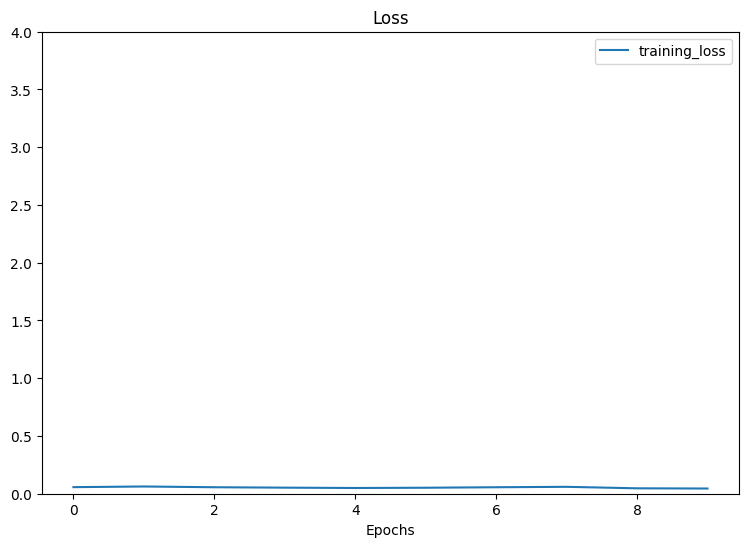

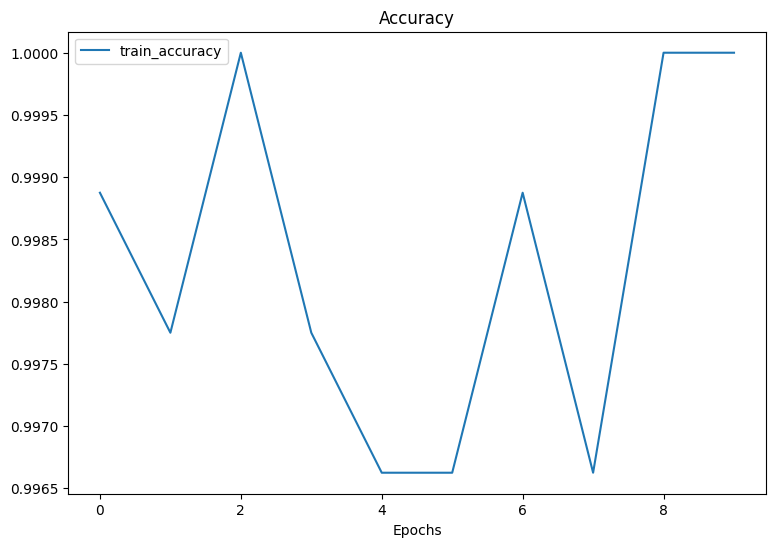

In [ ]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

# Hyperparameters
BEST_LR = 2e-5 # learning rate
BEST_WD= 2e-4 # weight decay
BEST_NUM_EPOCHS = 10 # number of epochs for training
cosine_scheduler = False # Set to True if using cosine decay, False if using fixed learning rate
if cosine_scheduler:
    print(f"Using cosine decay: {cosine_scheduler}")

train_for_more_epochs = False

# Filepath to save/load the model
SAVED_MODEL_FILEPATH = "/home/diogommiranda/tese/outputs/best_model.pth"

# Load saved model or train anew
if train_for_more_epochs:
    model.load_state_dict(torch.load(SAVED_MODEL_FILEPATH, weights_only=True, map_location=device)) # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
else:
    model = ResNet(
        block='basic',
        layers=[3, 4, 6, 3],
        block_inplanes=[64, 128, 256, 512],
        spatial_dims=3,
        n_input_channels=1,
        conv1_t_stride=2,
        num_classes=1,
        shortcut_type='B',
        bias_downsample=False
    )
    model.to(device)

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD)
optimizer = torch.optim.SGD(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD, momentum=0.9, nesterov=True)

# Save optimizer name to use in the saving files
optimizer_name = optimizer.__class__.__name__

scheduler = None
if cosine_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7) # T_max=100 for 100 epochs (used in CV)

history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': []}

for epoch in tqdm(range(BEST_NUM_EPOCHS)):
    epoch_start_time = time.time()
    history['epoch'].append(epoch + 1)

    model.train()
    running_loss = 0.0
    train_pred_probs = []
    train_targets = []

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        
        prob_outputs = torch.sigmoid(outputs)
        train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    train_targets = np.array(train_targets).flatten()
    train_pred_probs = np.array(train_pred_probs).flatten()
    
    # Calculate training metrics for the epoch
    train_loss = running_loss / len(train_data.dataset)
    train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
    train_auc = roc_auc_score(train_targets, train_pred_probs)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_auc'].append(train_auc)
        
    epoch_duration = time.time() - epoch_start_time
    print(f"    Epoch {epoch+1}/{BEST_NUM_EPOCHS} [{epoch_duration:.2f}s] - Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")
    
    if scheduler:
        scheduler.step()

# Save the model if using fixed learning rate in case we want to continue training it
if not cosine_scheduler:
    torch.save(model.state_dict(), SAVED_MODEL_FILEPATH)
    print(f"Model saved to: {SAVED_MODEL_FILEPATH}")

plot_loss_curves(history)

# Evaluate the model on the test data
model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")


--- Evaluation Metrics on Test Set ---
Accuracy:    0.8190
Sensitivity: 0.6538
Specificity: 0.9091 
Balanced Accuracy (BACC): 0.7815
F1 Score (Weighted):      0.8143
Matthews Corr Coef (MCC): 0.5931
Area Under the Curve (AUC): 0.7815



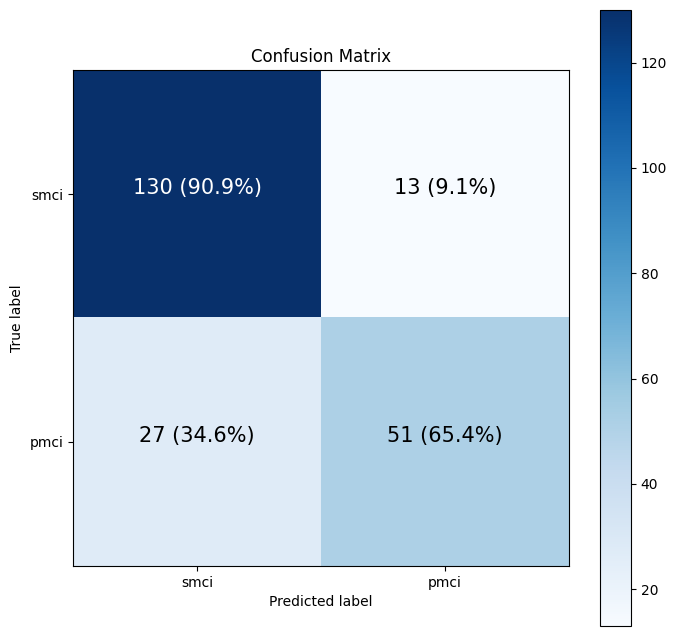

In [14]:
y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


# Save the model

In [12]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    
    # Configure the right path
    if USE_MASK:
        dir1 = "masked/"
    else:
        dir1 = "full_brain/"
    if cosine_scheduler:
        dir2 = "cosine_decay/"
    else:
        dir2 = "fixed_lr/"
        
    save_model_dir = "/home/diogommiranda/tese/outputs/torch/" + dir1 + DATASET + "/" + dir2 + "saved_models/" + str(BATCH_SIZE) + "B" + f"/LR={BEST_LR:.1e}_WD={BEST_WD:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), os.path.join(save_model_dir, "model.pth"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{test_loss}, {test_acc}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")
        
    training_config = {
        "num_epochs": BEST_NUM_EPOCHS,
        "lr_scheduler": lr_scheduler,
        "optimizer": optimizer_name,
        "optimizer_params": {
            "lr": float(BEST_LR),
            "weight_decay": float(BEST_WD)
        },
        "batch_size": BATCH_SIZE,
        "seed": seed,
        "dataset": DATASET
    }
    params_file_path = os.path.join(save_model_dir, "training_config.json")
    with open(params_file_path, "w") as f:
        json.dump(training_config, f, indent=4)

Saving model to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04


# Load a model and try it

  Train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312
Test Loss: 0.7523062952638212, Test Acc: 0.8099547511312217

--- Evaluation Metrics on Test Set ---
Accuracy:    0.8100
Sensitivity: 0.7436
Specificity: 0.8462 
Balanced Accuracy (BACC): 0.7949
F1 Score (Weighted):      0.8105
Matthews Corr Coef (MCC): 0.5864
Area Under the Curve (AUC): 0.7949



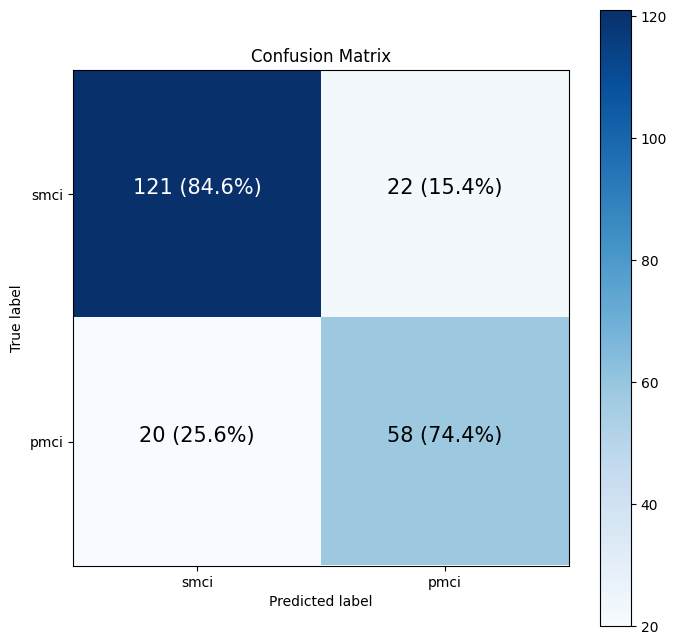

In [ ]:
load_model = ResNet(
        block='basic',
        layers=[3, 4, 6, 3],
        block_inplanes=[64, 128, 256, 512],
        spatial_dims=3,
        n_input_channels=1,
        conv1_t_stride=2,
        num_classes=1,
        shortcut_type='B',
        bias_downsample=False
        )
load_model.to(device)
save_model_dir = "/home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/LR=1.0e-05_WD=1e-04 (sgd) (4B)"
load_model.load_state_dict(torch.load(os.path.join(save_model_dir, "model.pth"), map_location=device))

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

# Evaluate the model on the test data
load_model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = load_model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)
